# Entrenamiento arquitectura recurrente con espectrograma
-----
En este notebook se realiza el entrenamiento de la arquitectura recurrente con normalización de estandar utilizada para el desarrollo del trabajo de grado titulado: "Clasificación de patologías cardiovasculares con máquinas de aprendizaje profundo a partir de señales ECG".

En este caso, se realiza la base de datos utilizada implementa la normalización estandar de la señal, esto es:

$$N_{Estandar}=\frac{Se\tilde{n}al_{Original}-Prom\left (Se\tilde{n}al_{Original}  \right )}{Desviaci\acute{o}n_{Estandar}\left (Se\tilde{n}al_{Original}  \right )}$$

# Importando Librerías

In [2]:
import optuna
import plotly
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, regularizers, initializers, callbacks
import random as python_random
from numpy.random import seed
np.random.seed(123)
tf.random.set_seed(11)
python_random.seed(123)
os.environ['PYTHONHASHSEED'] = '0'
from keras import backend as K
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
import json


# Definiendo funciones

In [33]:
TAMANIO=60

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def plot_confusion_matrix(cm, classes,ruta,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2. 
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gcf().set_size_inches(6,5)
    plt.savefig(ruta,dpi=300)
    plt.show()
def codificacion(tamano,unico=True,numero=0):
    #Vector de unos
    if unico==True:
        Y_train=np.ones(tamano)*numero
    else:
        for i in range(0,5):
            if i==0:
                Y_train=np.ones(tamano)*i
            else:
                vectorUnos=np.ones(tamano)
                Y_train=np.insert(Y_train,len(Y_train),vectorUnos*i,axis=0)
    return Y_train

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 1)
    tf.compat.v1.GPUOptions(visible_device_list = "0")
    set_session(tf.compat.v1.Session(config=config))

def load_data_test_gru():
    # load your data using this function
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NS\\ECG_'
    #importando patologias
    ECG_Normal_Test=np.load(path+'Normal\\ECG_Normal_test.npy')
    ECG_SBR_Test=np.load(path+'SBR\\ECG_SBR_Original.npy')
    ECG_SBR_Test=ECG_SBR_Test[300:360,:,:]
    ECG_AFIB_Test=np.load(path+'AFIB\\ECG_AFIB_test.npy')
    ECG_STD_Test=np.load(path+'STD\\ECG_STD_test.npy')
    ECG_STE_Test=np.load(path+'STE\\ECG_STE_test.npy')

    filas_seleccionadas = np.random.choice(len(ECG_Normal_Test), size=TAMANIO, replace=False)
    ECG_Normal_Test = ECG_Normal_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_AFIB_Test), size=TAMANIO, replace=False)
    ECG_AFIB_Test = ECG_AFIB_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STD_Test), size=TAMANIO, replace=False)
    ECG_STD_Test = ECG_STD_Test[filas_seleccionadas]
    filas_seleccionadas = np.random.choice(len(ECG_STE_Test), size=TAMANIO, replace=False)
    ECG_STE_Test = ECG_STE_Test[filas_seleccionadas]
    

    y_Normal_Test=codificacion(len(ECG_Normal_Test),True,0)
    y_SBR_Test=codificacion(len(ECG_SBR_Test),True,1)
    y_AFIB_Test=codificacion(len(ECG_AFIB_Test),True,2)
    y_STD_Test=codificacion(len(ECG_STD_Test),True,3)
    y_STE_Test=codificacion(len(ECG_STE_Test),True,4)
    
    #Uniendo canales
    ECG_Normal_Test=np.concatenate((ECG_Normal_Test[:,:,:,0],ECG_Normal_Test[:,:,:,1]),axis=1)
    ECG_SBR_Test=np.concatenate((ECG_SBR_Test[:,:,:,0],ECG_SBR_Test[:,:,:,1]),axis=1)
    ECG_AFIB_Test=np.concatenate((ECG_AFIB_Test[:,:,:,0],ECG_AFIB_Test[:,:,:,1]),axis=1)
    ECG_STE_Test=np.concatenate((ECG_STE_Test[:,:,:,0],ECG_STE_Test[:,:,:,1]),axis=1)
    ECG_STD_Test=np.concatenate((ECG_STD_Test[:,:,:,0],ECG_STD_Test[:,:,:,1]),axis=1)

    #Generando X_train
    X_test=np.concatenate((ECG_Normal_Test,
                                ECG_SBR_Test,
                                ECG_AFIB_Test,
                                ECG_STE_Test,
                                ECG_STD_Test))

    Y_test=np.insert(y_Normal_Test,len(y_Normal_Test),y_SBR_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_AFIB_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STD_Test,axis=0)
    Y_test=np.insert(Y_test,len(Y_test),y_STE_Test,axis=0)    

    print('Tamaño datos test: '+ str(X_test.shape))
    print('Tamaño etiquetas de test: '+str(Y_test.shape))
    
    X_test=np.moveaxis(X_test,1,2)   
    return X_test,Y_test
def load_data_gru():
    path='C:\\Users\jdani\\Documents\\TrabajoDeGrado\\BDConEspectrograma\\MatricesNumpyGuardadas_NS\\ECG_'
    #importando patologias
    ECG_Normal_Original=np.load(path+'Normal\\ECG_Normal_Original.npy')
    ECG_SBR_Original=np.load(path+'SBR\\ECG_SBR_Original.npy')
    print(ECG_SBR_Original.shape)
    ECG_AFIB_Original=np.load(path+'AFIB\\ECG_AFIB_Original.npy')
    ECG_STD_Original=np.load(path+'STD\\ECG_STD_Original.npy')
    ECG_STE_Original=np.load(path+'STE\\ECG_STE_Original.npy')
        
    # partiendo base de datos y generando labels
    ECG_Normal_Train=ECG_Normal_Original[:,:,:]
    y_Normal_Train=codificacion(len(ECG_Normal_Train),True,0)
    ECG_SBR_Train=ECG_SBR_Original[:300,:,:]
    y_SBR_Train=codificacion(len(ECG_SBR_Train),True,1)
    ECG_AFIB_Train=ECG_AFIB_Original[:,:,:]
    y_AFIB_Train=codificacion(len(ECG_AFIB_Train),True,2)
    ECG_STD_Train=ECG_STD_Original[:,:,:]
    y_STD_Train=codificacion(len(ECG_STD_Train),True,3)
    ECG_STE_Train=ECG_STE_Original[:,:,:]
    y_STE_Train=codificacion(len(ECG_STE_Train),True,4)
    
    #Uniendo canales
    ECG_Normal_Train=np.concatenate((ECG_Normal_Train[:,:,:,0],ECG_Normal_Train[:,:,:,1]),axis=1)
    ECG_SBR_Train=np.concatenate((ECG_SBR_Train[:,:,:,0],ECG_SBR_Train[:,:,:,1]),axis=1)
    ECG_AFIB_Train=np.concatenate((ECG_AFIB_Train[:,:,:,0],ECG_AFIB_Train[:,:,:,1]),axis=1)
    ECG_STE_Train=np.concatenate((ECG_STE_Train[:,:,:,0],ECG_STE_Train[:,:,:,1]),axis=1)
    ECG_STD_Train=np.concatenate((ECG_STD_Train[:,:,:,0],ECG_STD_Train[:,:,:,1]),axis=1)
    
    #Generando Y
    Y_train=np.insert(y_Normal_Train,len(y_Normal_Train),y_SBR_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_AFIB_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STD_Train,axis=0)
    Y_train=np.insert(Y_train,len(Y_train),y_STE_Train,axis=0)


    #Generando X_train

    X_train=np.concatenate((ECG_Normal_Train,
                                ECG_SBR_Train,
                                ECG_AFIB_Train,
                                ECG_STE_Train,
                                ECG_STD_Train))
    print('Tamaño datos entrenamiento: '+ str(X_train.shape))
    print('Tamaño etiquetas de entrenamiento: '+str(Y_train.shape))
    
    X_test,Y_test=load_data_test_gru()
    
    Y_train= keras.utils.to_categorical(Y_train)
    Y_test= keras.utils.to_categorical(Y_test)
    
    X_train=np.moveaxis(X_train,1,2)

    return X_train,Y_train,X_test,Y_test

In [3]:
X_train,Y_train,X_test,Y_test=load_data_gru()
X_train
X_test

print()
print()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)


(10015, 241, 102)
(10015, 5)
(300, 241, 102)
(300, 5)


# Creando modelo para optimización con Optuna

In [4]:
#Definiendo constantes
EPOCAS=30
ciclo=0
mejores={}
def modelo_GRU(trial):
    # n_hidden=trial.suggest_int('n_hidden',256,1024)
    drop_path_rate = trial.suggest_float("drop_path_rate", 0.5, 0.8, step=0.1)
    strides_num=trial.suggest_int('strides',1,10)
    # kernel_sizes=trial.suggest_int('kernel_sizes',3,100)
    kernel_sizes=trial.suggest_categorical('kernel_sizes', [3,6,9,12,15,18,21,24,25])
    n_filters=trial.suggest_int('n_filters',16,256)
    # input_shape = (1, 51, 482)
    input_shape = (1, 241, 102)
    # Regularización L2
    ModelGRU=keras.models.Sequential()

    ModelGRU.add(keras.layers.Conv1D(filters=n_filters,kernel_size=kernel_sizes,strides=strides_num,input_shape=input_shape[1:]))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Activation('relu'))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    
    ModelGRU.add(keras.layers.TimeDistributed(keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3))))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    ModelGRU.add(keras.layers.Flatten())
    # keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L2(1e-5))
    ModelGRU.add(keras.layers.Dense(64,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelGRU.add(keras.layers.Dropout(drop_path_rate))
    ModelGRU.add(keras.layers.Dense(5,activation="softmax",))  
    ModelGRU.summary()
    
    return ModelGRU

def create_optimizer_GRU(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    # optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = "Adam"
    # optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn_GRU(trial,model, optimizer, X,Y,X_test,Y_test):
    global ciclo
    global mejores
    batches=trial.suggest_int('batches',64,256)
    # val_split=trial.suggest_float('val_split',0.1,0.2,step=0.05)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
    Stop = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
    ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsOptuna\\NS\\'
    ruta_modelo_trial=ruta_modelo+'mejor_modelo_trial'+str(ciclo)+'.h5'
    Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
    history_GRU=model.fit(X,Y,verbose=1,validation_data=(X_test,Y_test),epochs=EPOCAS,batch_size=batches,callbacks=[Stop, Checkpoint])
    ciclo+=1
    mejores['trial '+str(ciclo)]=Checkpoint.best
    reset_keras()
    gc.collect()
    return history_GRU.history['val_accuracy'][-1]

def objective_GRU(trial):
    ##Datos
    X_train,y_train,X_test,y_test=load_data_gru()
    
    # Clear clutter from previous session graphs.
    # keras.backend.clear_session()
    #Contruyendo modelo y optimizador
    model=modelo_GRU(trial)
    optimizer=create_optimizer_GRU(trial)
    
    #Entrenando y validando
    loss=learn_GRU(trial,model,optimizer,X_train,y_train,X_test,y_test)
    # reset_keras()
    return loss

In [5]:
study_GRU=optuna.create_study(direction="maximize") #Para minimizar la función de pérdida

[I 2023-04-09 20:03:59,523] A new study created in memory with name: no-name-9d2a8366-b63b-4041-8b1d-83b7a710687a


In [6]:
study_GRU.optimize(objective_GRU,n_trials=50)

(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 22)            26950     
                                                                 
 batch_normalization (BatchN  (None, 33, 22)           88        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 22)            0         
                                                                 
 dropout (Dropout)           (None, 33, 22)            0         
                                                                 
 gru (GRU)                   (None, 33, 128)           58368     
            

[I 2023-04-09 20:05:24,300] Trial 0 finished with value: 0.800000011920929 and parameters: {'drop_path_rate': 0.5, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 22, 'adam_learning_rate': 2.0311632049557067e-05, 'batches': 149}. Best is trial 0 with value: 0.800000011920929.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 122)           298778    
                                                                 
 batch_normalization (BatchN  (None, 22, 122)          488       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 122)           0         
                                                                 
 dropout (Dropout)           (None, 22, 122)           0         
                                                                 
 gru (GRU)                   (None, 22, 128)           96768     
            

[I 2023-04-09 20:06:35,291] Trial 1 finished with value: 0.8033333420753479 and parameters: {'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 24, 'n_filters': 122, 'adam_learning_rate': 3.82360087769919e-05, 'batches': 151}. Best is trial 1 with value: 0.8033333420753479.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 115, 19)           23275     
                                                                 
 batch_normalization (BatchN  (None, 115, 19)          76        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 115, 19)           0         
                                                                 
 dropout (Dropout)           (None, 115, 19)           0         
                                                                 
 gru (GRU)                   (None, 115, 128)          57216     
            

[I 2023-04-09 20:08:55,531] Trial 2 finished with value: 0.49666666984558105 and parameters: {'drop_path_rate': 0.6, 'strides': 2, 'kernel_sizes': 12, 'n_filters': 19, 'adam_learning_rate': 1.3287878016416344e-05, 'batches': 130}. Best is trial 1 with value: 0.8033333420753479.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 124)           151900    
                                                                 
 batch_normalization (BatchN  (None, 58, 124)          496       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 58, 124)           0         
                                                                 
 dropout (Dropout)           (None, 58, 124)           0         
                                                                 
 gru (GRU)                   (None, 58, 128)           97536     
            

[I 2023-04-09 20:10:48,271] Trial 3 finished with value: 0.5133333206176758 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 12, 'n_filters': 124, 'adam_learning_rate': 0.00011129021375046642, 'batches': 85}. Best is trial 1 with value: 0.8033333420753479.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 243)           595107    
                                                                 
 batch_normalization (BatchN  (None, 22, 243)          972       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 243)           0         
                                                                 
 dropout (Dropout)           (None, 22, 243)           0         
                                                                 
 gru (GRU)                   (None, 22, 128)           143232    
      

[I 2023-04-09 20:11:50,720] Trial 4 finished with value: 0.7566666603088379 and parameters: {'drop_path_rate': 0.5, 'strides': 10, 'kernel_sizes': 24, 'n_filters': 243, 'adam_learning_rate': 0.0010373235352568217, 'batches': 245}. Best is trial 1 with value: 0.8033333420753479.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 227, 72)           110232    
                                                                 
 batch_normalization (BatchN  (None, 227, 72)          288       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 72)           0         
                                                                 
 dropout (Dropout)           (None, 227, 72)           0         
                                                                 
 gru (GRU)                   (None, 227, 128)          77568     
            

[I 2023-04-09 20:15:55,957] Trial 5 finished with value: 0.8166666626930237 and parameters: {'drop_path_rate': 0.8, 'strides': 1, 'kernel_sizes': 15, 'n_filters': 72, 'adam_learning_rate': 0.0026510901365895097, 'batches': 222}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 238)           607138    
                                                                 
 batch_normalization (BatchN  (None, 44, 238)          952       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 238)           0         
                                                                 
 dropout (Dropout)           (None, 44, 238)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           141312    
            

[I 2023-04-09 20:17:23,878] Trial 6 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 25, 'n_filters': 238, 'adam_learning_rate': 0.04110551944971812, 'batches': 158}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 236, 171)          104823    
                                                                 
 batch_normalization (BatchN  (None, 236, 171)         684       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 236, 171)          0         
                                                                 
 dropout (Dropout)           (None, 236, 171)          0         
                                                                 
 gru (GRU)                   (None, 236, 128)          115584    
            

[I 2023-04-09 20:22:12,935] Trial 7 finished with value: 0.7900000214576721 and parameters: {'drop_path_rate': 0.7, 'strides': 1, 'kernel_sizes': 6, 'n_filters': 171, 'adam_learning_rate': 0.0001967766623000931, 'batches': 184}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 227, 26)           39806     
                                                                 
 batch_normalization (BatchN  (None, 227, 26)          104       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 227, 26)           0         
                                                                 
 dropout (Dropout)           (None, 227, 26)           0         
                                                                 
 gru (GRU)                   (None, 227, 128)          59904     
            

[I 2023-04-09 20:25:52,924] Trial 8 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'strides': 1, 'kernel_sizes': 15, 'n_filters': 26, 'adam_learning_rate': 0.0441550725360639, 'batches': 185}. Best is trial 5 with value: 0.8166666626930237.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 89)            227039    
                                                                 
 batch_normalization (BatchN  (None, 22, 89)           356       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 22, 89)            0         
                                                                 
 dropout (Dropout)           (None, 22, 89)            0         
                                                                 
 gru (GRU)                   (None, 22, 128)           84096     
      

[I 2023-04-09 20:26:37,498] Trial 9 finished with value: 0.23000000417232513 and parameters: {'drop_path_rate': 0.8, 'strides': 10, 'kernel_sizes': 25, 'n_filters': 89, 'adam_learning_rate': 0.008891210812049641, 'batches': 105}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 75, 88)            161656    
                                                                 
 batch_normalization (BatchN  (None, 75, 88)           352       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 75, 88)            0         
                                                                 
 dropout (Dropout)           (None, 75, 88)            0         
                                                                 
 gru (GRU)                   (None, 75, 128)           83712     
            

[I 2023-04-09 20:28:28,262] Trial 10 finished with value: 0.7566666603088379 and parameters: {'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 18, 'n_filters': 88, 'adam_learning_rate': 0.0019542318816331383, 'batches': 255}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 34, 157)           144283    
                                                                 
 batch_normalization (BatchN  (None, 34, 157)          628       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 34, 157)           0         
                                                                 
 dropout (Dropout)           (None, 34, 157)           0         
                                                                 
 gru (GRU)                   (None, 34, 128)           110208    
            

[I 2023-04-09 20:29:35,325] Trial 11 finished with value: 0.800000011920929 and parameters: {'drop_path_rate': 0.6, 'strides': 7, 'kernel_sizes': 9, 'n_filters': 157, 'adam_learning_rate': 0.0002313893057887828, 'batches': 218}. Best is trial 5 with value: 0.8166666626930237.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 79)            24253     
                                                                 
 batch_normalization (BatchN  (None, 30, 79)           316       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 79)            0         
                                                                 
 dropout (Dropout)           (None, 30, 79)            0         
                                                                 
 gru (GRU)                   (None, 30, 128)           80256     
      

[I 2023-04-09 20:30:34,048] Trial 12 finished with value: 0.7833333611488342 and parameters: {'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 3, 'n_filters': 79, 'adam_learning_rate': 0.003998424902641496, 'batches': 199}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 124)           303676    
                                                                 
 batch_normalization (BatchN  (None, 28, 124)          496       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 124)           0         
                                                                 
 dropout (Dropout)           (None, 28, 124)           0         
                                                                 
 gru (GRU)                   (None, 28, 128)           97536     
            

[I 2023-04-09 20:31:34,507] Trial 13 finished with value: 0.8133333325386047 and parameters: {'drop_path_rate': 0.5, 'strides': 8, 'kernel_sizes': 24, 'n_filters': 124, 'adam_learning_rate': 0.0005163792509430278, 'batches': 219}. Best is trial 5 with value: 0.8166666626930237.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 61)            130723    
                                                                 
 batch_normalization (BatchN  (None, 28, 61)           244       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 61)            0         
                                                                 
 dropout (Dropout)           (None, 28, 61)            0         
                                                                 
 gru (GRU)                   (None, 28, 128)           73344     
            

[I 2023-04-09 20:32:30,356] Trial 14 finished with value: 0.7766666412353516 and parameters: {'drop_path_rate': 0.6, 'strides': 8, 'kernel_sizes': 21, 'n_filters': 61, 'adam_learning_rate': 0.0005515990489710548, 'batches': 222}. Best is trial 5 with value: 0.8166666626930237.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 188)           287828    
                                                                 
 batch_normalization (BatchN  (None, 38, 188)          752       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 188)           0         
                                                                 
 dropout (Dropout)           (None, 38, 188)           0         
                                                                 
 gru (GRU)                   (None, 38, 128)           122112    
      

[I 2023-04-09 20:33:26,201] Trial 15 finished with value: 0.9100000262260437 and parameters: {'drop_path_rate': 0.7, 'strides': 6, 'kernel_sizes': 15, 'n_filters': 188, 'adam_learning_rate': 0.0066398097694950866, 'batches': 223}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 181)           277111    
                                                                 
 batch_normalization (BatchN  (None, 46, 181)          724       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 181)           0         
                                                                 
 dropout (Dropout)           (None, 46, 181)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           119424    
      

[I 2023-04-09 20:34:29,910] Trial 16 finished with value: 0.38999998569488525 and parameters: {'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 15, 'n_filters': 181, 'adam_learning_rate': 0.0071842552229915225, 'batches': 240}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 76, 211)           323041    
                                                                 
 batch_normalization (BatchN  (None, 76, 211)          844       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 76, 211)           0         
                                                                 
 dropout (Dropout)           (None, 76, 211)           0         
                                                                 
 gru (GRU)                   (None, 76, 128)           130944    
      

[I 2023-04-09 20:35:37,780] Trial 17 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 15, 'n_filters': 211, 'adam_learning_rate': 0.011770824226140965, 'batches': 195}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 214)           327634    
                                                                 
 batch_normalization (BatchN  (None, 38, 214)          856       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 214)           0         
                                                                 
 dropout (Dropout)           (None, 38, 214)           0         
                                                                 
 gru (GRU)                   (None, 38, 128)           132096    
      

[I 2023-04-09 20:36:57,383] Trial 18 finished with value: 0.8199999928474426 and parameters: {'drop_path_rate': 0.8, 'strides': 6, 'kernel_sizes': 15, 'n_filters': 214, 'adam_learning_rate': 0.002329427838135547, 'batches': 231}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 223)           341413    
                                                                 
 batch_normalization (BatchN  (None, 38, 223)          892       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 223)           0         
                                                                 
 dropout (Dropout)           (None, 38, 223)           0         
                                                                 
 gru (GRU)                   (None, 38, 128)           135552    
      

[I 2023-04-09 20:37:57,294] Trial 19 finished with value: 0.20000000298023224 and parameters: {'drop_path_rate': 0.7, 'strides': 6, 'kernel_sizes': 15, 'n_filters': 223, 'adam_learning_rate': 0.09533601840442224, 'batches': 203}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 197)           120761    
                                                                 
 batch_normalization (BatchN  (None, 40, 197)          788       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 197)           0         
                                                                 
 dropout (Dropout)           (None, 40, 197)           0         
                                                                 
 gru (GRU)                   (None, 40, 128)           125568    
      

[I 2023-04-09 20:39:13,924] Trial 20 finished with value: 0.753333330154419 and parameters: {'drop_path_rate': 0.8, 'strides': 6, 'kernel_sizes': 6, 'n_filters': 197, 'adam_learning_rate': 0.0011983409349954218, 'batches': 175}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 155)           237305    
                                                                 
 batch_normalization (BatchN  (None, 57, 155)          620       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 57, 155)           0         
                                                                 
 dropout (Dropout)           (None, 57, 155)           0         
                                                                 
 gru (GRU)                   (None, 57, 128)           109440    
      

[I 2023-04-09 20:40:51,852] Trial 21 finished with value: 0.8533333539962769 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 15, 'n_filters': 155, 'adam_learning_rate': 0.002887730856106812, 'batches': 226}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 156)           238836    
                                                                 
 batch_normalization (BatchN  (None, 57, 156)          624       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 57, 156)           0         
                                                                 
 dropout (Dropout)           (None, 57, 156)           0         
                                                                 
 gru (GRU)                   (None, 57, 128)           109824    
            

[I 2023-04-09 20:42:28,939] Trial 22 finished with value: 0.8366666436195374 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 15, 'n_filters': 156, 'adam_learning_rate': 0.0034975562328062025, 'batches': 235}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 152)           232712    
                                                                 
 batch_normalization (BatchN  (None, 57, 152)          608       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 57, 152)           0         
                                                                 
 dropout (Dropout)           (None, 57, 152)           0         
                                                                 
 gru (GRU)                   (None, 57, 128)           108288    
      

[I 2023-04-09 20:43:49,713] Trial 23 finished with value: 0.8766666650772095 and parameters: {'drop_path_rate': 0.7, 'strides': 4, 'kernel_sizes': 15, 'n_filters': 152, 'adam_learning_rate': 0.005201451542478772, 'batches': 256}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 145)           266365    
                                                                 
 batch_normalization (BatchN  (None, 56, 145)          580       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 56, 145)           0         
                                                                 
 dropout (Dropout)           (None, 56, 145)           0         
                                                                 
 gru (GRU)                   (None, 56, 128)           105600    
            

[I 2023-04-09 20:44:36,299] Trial 24 finished with value: 0.2966666519641876 and parameters: {'drop_path_rate': 0.7, 'strides': 4, 'kernel_sizes': 18, 'n_filters': 145, 'adam_learning_rate': 0.018685367736040147, 'batches': 256}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 74, 190)           407170    
                                                                 
 batch_normalization (BatchN  (None, 74, 190)          760       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 74, 190)           0         
                                                                 
 dropout (Dropout)           (None, 74, 190)           0         
                                                                 
 gru (GRU)                   (None, 74, 128)           122880    
      

[I 2023-04-09 20:46:09,232] Trial 25 finished with value: 0.7166666388511658 and parameters: {'drop_path_rate': 0.7, 'strides': 3, 'kernel_sizes': 21, 'n_filters': 190, 'adam_learning_rate': 0.006068831776200793, 'batches': 205}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 47, 110)           101090    
                                                                 
 batch_normalization (BatchN  (None, 47, 110)          440       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 47, 110)           0         
                                                                 
 dropout (Dropout)           (None, 47, 110)           0         
                                                                 
 gru (GRU)                   (None, 47, 128)           92160     
      

[I 2023-04-09 20:46:49,051] Trial 26 finished with value: 0.3933333456516266 and parameters: {'drop_path_rate': 0.7, 'strides': 5, 'kernel_sizes': 9, 'n_filters': 110, 'adam_learning_rate': 0.016279946745667496, 'batches': 245}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 168)           51576     
                                                                 
 batch_normalization (BatchN  (None, 60, 168)          672       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 60, 168)           0         
                                                                 
 dropout (Dropout)           (None, 60, 168)           0         
                                                                 
 gru (GRU)                   (None, 60, 128)           114432    
            

[I 2023-04-09 20:48:08,024] Trial 27 finished with value: 0.800000011920929 and parameters: {'drop_path_rate': 0.6, 'strides': 4, 'kernel_sizes': 3, 'n_filters': 168, 'adam_learning_rate': 0.004789782687828474, 'batches': 65}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 114, 143)          218933    
                                                                 
 batch_normalization (BatchN  (None, 114, 143)         572       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 114, 143)          0         
                                                                 
 dropout (Dropout)           (None, 114, 143)          0         
                                                                 
 gru (GRU)                   (None, 114, 128)          104832    
      

[I 2023-04-09 20:49:48,769] Trial 28 finished with value: 0.7099999785423279 and parameters: {'drop_path_rate': 0.7, 'strides': 2, 'kernel_sizes': 15, 'n_filters': 143, 'adam_learning_rate': 0.00693588078092844, 'batches': 209}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 197)           301607    
                                                                 
 batch_normalization (BatchN  (None, 33, 197)          788       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 197)           0         
                                                                 
 dropout (Dropout)           (None, 33, 197)           0         
                                                                 
 gru (GRU)                   (None, 33, 128)           125568    
      

[I 2023-04-09 20:51:11,491] Trial 29 finished with value: 0.8133333325386047 and parameters: {'drop_path_rate': 0.7, 'strides': 7, 'kernel_sizes': 15, 'n_filters': 197, 'adam_learning_rate': 0.00179425547917977, 'batches': 125}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 108)           165348    
                                                                 
 batch_normalization (BatchN  (None, 46, 108)          432       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 108)           0         
                                                                 
 dropout (Dropout)           (None, 46, 108)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           91392     
      

[I 2023-04-09 20:51:55,440] Trial 30 finished with value: 0.4300000071525574 and parameters: {'drop_path_rate': 0.6, 'strides': 5, 'kernel_sizes': 15, 'n_filters': 108, 'adam_learning_rate': 0.014461424122502932, 'batches': 171}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 157)           240367    
                                                                 
 batch_normalization (BatchN  (None, 57, 157)          628       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 57, 157)           0         
                                                                 
 dropout (Dropout)           (None, 57, 157)           0         
                                                                 
 gru (GRU)                   (None, 57, 128)           110208    
      

[I 2023-04-09 20:53:33,445] Trial 31 finished with value: 0.7933333516120911 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 15, 'n_filters': 157, 'adam_learning_rate': 0.0037593331859017347, 'batches': 234}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 76, 156)           238836    
                                                                 
 batch_normalization (BatchN  (None, 76, 156)          624       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 76, 156)           0         
                                                                 
 dropout (Dropout)           (None, 76, 156)           0         
                                                                 
 gru (GRU)                   (None, 76, 128)           109824    
            

[I 2023-04-09 20:55:36,844] Trial 32 finished with value: 0.8233333230018616 and parameters: {'drop_path_rate': 0.8, 'strides': 3, 'kernel_sizes': 15, 'n_filters': 156, 'adam_learning_rate': 0.003624681865402818, 'batches': 233}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 135)           206685    
                                                                 
 batch_normalization (BatchN  (None, 57, 135)          540       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 57, 135)           0         
                                                                 
 dropout (Dropout)           (None, 57, 135)           0         
                                                                 
 gru (GRU)                   (None, 57, 128)           101760    
      

[I 2023-04-09 20:57:10,861] Trial 33 finished with value: 0.7799999713897705 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 15, 'n_filters': 135, 'adam_learning_rate': 0.001297276863191474, 'batches': 254}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 115, 176)          215600    
                                                                 
 batch_normalization (BatchN  (None, 115, 176)         704       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 115, 176)          0         
                                                                 
 dropout (Dropout)           (None, 115, 176)          0         
                                                                 
 gru (GRU)                   (None, 115, 128)          117504    
      

[I 2023-04-09 20:59:59,734] Trial 34 finished with value: 0.75 and parameters: {'drop_path_rate': 0.8, 'strides': 2, 'kernel_sizes': 12, 'n_filters': 176, 'adam_learning_rate': 0.002904522533928314, 'batches': 229}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 133)           203623    
                                                                 
 batch_normalization (BatchN  (None, 38, 133)          532       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 133)           0         
                                                                 
 dropout (Dropout)           (None, 38, 133)           0         
                                                                 
 gru (GRU)                   (None, 38, 128)           100992    
            

[I 2023-04-09 21:00:53,062] Trial 35 finished with value: 0.5199999809265137 and parameters: {'drop_path_rate': 0.7, 'strides': 6, 'kernel_sizes': 15, 'n_filters': 133, 'adam_learning_rate': 0.00881874451097478, 'batches': 244}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 55, 113)           276737    
                                                                 
 batch_normalization (BatchN  (None, 55, 113)          452       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 55, 113)           0         
                                                                 
 dropout (Dropout)           (None, 55, 113)           0         
                                                                 
 gru (GRU)                   (None, 55, 128)           93312     
            

[I 2023-04-09 21:02:16,291] Trial 36 finished with value: 0.6899999976158142 and parameters: {'drop_path_rate': 0.8, 'strides': 4, 'kernel_sizes': 24, 'n_filters': 113, 'adam_learning_rate': 0.005140134445040742, 'batches': 212}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 189)           231525    
                                                                 
 batch_normalization (BatchN  (None, 46, 189)          756       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 189)           0         
                                                                 
 dropout (Dropout)           (None, 46, 189)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           122496    
      

[I 2023-04-09 21:03:39,875] Trial 37 finished with value: 0.8433333039283752 and parameters: {'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 12, 'n_filters': 189, 'adam_learning_rate': 0.0017376782392358391, 'batches': 241}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44, 232)           591832    
                                                                 
 batch_normalization (BatchN  (None, 44, 232)          928       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44, 232)           0         
                                                                 
 dropout (Dropout)           (None, 44, 232)           0         
                                                                 
 gru (GRU)                   (None, 44, 128)           139008    
            

[I 2023-04-09 21:05:23,703] Trial 38 finished with value: 0.8199999928474426 and parameters: {'drop_path_rate': 0.7, 'strides': 5, 'kernel_sizes': 25, 'n_filters': 232, 'adam_learning_rate': 0.0007579769281836078, 'batches': 140}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 187)           229075    
                                                                 
 batch_normalization (BatchN  (None, 33, 187)          748       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 33, 187)           0         
                                                                 
 dropout (Dropout)           (None, 33, 187)           0         
                                                                 
 gru (GRU)                   (None, 33, 128)           121728    
            

[I 2023-04-09 21:06:25,857] Trial 39 finished with value: 0.8233333230018616 and parameters: {'drop_path_rate': 0.5, 'strides': 7, 'kernel_sizes': 12, 'n_filters': 187, 'adam_learning_rate': 0.0017054582364247296, 'batches': 247}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 205)           251125    
                                                                 
 batch_normalization (BatchN  (None, 46, 205)          820       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 205)           0         
                                                                 
 dropout (Dropout)           (None, 46, 205)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           128640    
      

[I 2023-04-09 21:07:54,533] Trial 40 finished with value: 0.8399999737739563 and parameters: {'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 12, 'n_filters': 205, 'adam_learning_rate': 0.0008800823817137771, 'batches': 192}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 46, 203)           248675    
                                                                 
 batch_normalization (BatchN  (None, 46, 203)          812       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 203)           0         
                                                                 
 dropout (Dropout)           (None, 46, 203)           0         
                                                                 
 gru (GRU)                   (None, 46, 128)           127872    
      

[I 2023-04-09 21:09:22,466] Trial 41 finished with value: 0.8333333134651184 and parameters: {'drop_path_rate': 0.8, 'strides': 5, 'kernel_sizes': 12, 'n_filters': 203, 'adam_learning_rate': 0.0009532250961524344, 'batches': 189}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 174)           213150    
                                                                 
 batch_normalization (BatchN  (None, 39, 174)          696       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 39, 174)           0         
                                                                 
 dropout (Dropout)           (None, 39, 174)           0         
                                                                 
 gru (GRU)                   (None, 39, 128)           116736    
            

[I 2023-04-09 21:10:37,443] Trial 42 finished with value: 0.8566666841506958 and parameters: {'drop_path_rate': 0.8, 'strides': 6, 'kernel_sizes': 12, 'n_filters': 174, 'adam_learning_rate': 0.0021075270201401696, 'batches': 225}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 170)           208250    
                                                                 
 batch_normalization (BatchN  (None, 39, 170)          680       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 39, 170)           0         
                                                                 
 dropout (Dropout)           (None, 39, 170)           0         
                                                                 
 gru (GRU)                   (None, 39, 128)           115200    
      

[I 2023-04-09 21:11:53,454] Trial 43 finished with value: 0.8766666650772095 and parameters: {'drop_path_rate': 0.8, 'strides': 6, 'kernel_sizes': 12, 'n_filters': 170, 'adam_learning_rate': 0.0024481984000359904, 'batches': 222}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 168)           205800    
                                                                 
 batch_normalization (BatchN  (None, 39, 168)          672       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 39, 168)           0         
                                                                 
 dropout (Dropout)           (None, 39, 168)           0         
                                                                 
 gru (GRU)                   (None, 39, 128)           114432    
      

[I 2023-04-09 21:13:07,134] Trial 44 finished with value: 0.8199999928474426 and parameters: {'drop_path_rate': 0.8, 'strides': 6, 'kernel_sizes': 12, 'n_filters': 168, 'adam_learning_rate': 0.002727165871304058, 'batches': 221}. Best is trial 15 with value: 0.9100000262260437.


41842
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 145)           88885     
                                                                 
 batch_normalization (BatchN  (None, 40, 145)          580       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 145)           0         
                                                                 
 dropout (Dropout)           (None, 40, 145)           0         
                                                                 
 gru (GRU)                   (None, 40, 128)           105600    
      

[I 2023-04-09 21:14:05,004] Trial 45 finished with value: 0.7699999809265137 and parameters: {'drop_path_rate': 0.7, 'strides': 6, 'kernel_sizes': 6, 'n_filters': 145, 'adam_learning_rate': 0.004743589007680602, 'batches': 173}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 169)           310453    
                                                                 
 batch_normalization (BatchN  (None, 32, 169)          676       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 169)           0         
                                                                 
 dropout (Dropout)           (None, 32, 169)           0         
                                                                 
 gru (GRU)                   (None, 32, 128)           114816    
            

[I 2023-04-09 21:14:50,394] Trial 46 finished with value: 0.3199999928474426 and parameters: {'drop_path_rate': 0.8, 'strides': 7, 'kernel_sizes': 18, 'n_filters': 169, 'adam_learning_rate': 0.01030761401891185, 'batches': 211}. Best is trial 15 with value: 0.9100000262260437.


41859
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 178)           218050    
                                                                 
 batch_normalization (BatchN  (None, 26, 178)          712       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 178)           0         
                                                                 
 dropout (Dropout)           (None, 26, 178)           0         
                                                                 
 gru (GRU)                   (None, 26, 128)           118272    
      

[I 2023-04-09 21:15:55,590] Trial 47 finished with value: 0.7933333516120911 and parameters: {'drop_path_rate': 0.8, 'strides': 9, 'kernel_sizes': 12, 'n_filters': 178, 'adam_learning_rate': 0.0029170023793033727, 'batches': 226}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 160)           147040    
                                                                 
 batch_normalization (BatchN  (None, 30, 160)          640       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 160)           0         
                                                                 
 dropout (Dropout)           (None, 30, 160)           0         
                                                                 
 gru (GRU)                   (None, 30, 128)           111360    
            

[I 2023-04-09 21:16:50,872] Trial 48 finished with value: 0.8399999737739563 and parameters: {'drop_path_rate': 0.7, 'strides': 8, 'kernel_sizes': 9, 'n_filters': 160, 'adam_learning_rate': 0.005785440783412344, 'batches': 213}. Best is trial 15 with value: 0.9100000262260437.


(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 124)           38068     
                                                                 
 batch_normalization (BatchN  (None, 35, 124)          496       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 35, 124)           0         
                                                                 
 dropout (Dropout)           (None, 35, 124)           0         
                                                                 
 gru (GRU)                   (None, 35, 128)           97536     
            

[I 2023-04-09 21:17:59,778] Trial 49 finished with value: 0.8299999833106995 and parameters: {'drop_path_rate': 0.7, 'strides': 7, 'kernel_sizes': 3, 'n_filters': 124, 'adam_learning_rate': 0.0021812015888688745, 'batches': 250}. Best is trial 15 with value: 0.9100000262260437.


# Graficas obtenidas de la optimización

In [7]:
# import plotly.io as pio
fig = optuna.visualization.plot_param_importances(study_GRU)
# pio.write_image(fig, 'nombre_del_archivo.png')
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Importancia de los hiperparámetros en la optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [8]:
fig = optuna.visualization.plot_contour(study_GRU, params=["adam_learning_rate", "n_filters"],target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text':"Gráfico de líneas de contorno",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show( config=config)

In [9]:
fig = optuna.visualization.plot_optimization_history(study_GRU,target_name="Val_accuracy")
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1000,
    'scale':4 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.update_layout(title={
                    'text': "Gráfico de historial de optimización",
                    'x':0.5, #Centrar el título horizontalmente
                    'y':0.90, #Posicionar el título en la parte superior
                    'xanchor': 'center',
                    'yanchor': 'top'})

fig.show( config=config)

In [11]:
#Ubicacion del mejor modelo entrenado
max_key = None
max_value = float('-inf')

for key, value in mejores.items():
    if value > max_value:
        max_key = key
        max_value = value

print(f"La clave con el valor más alto es '{max_key}' con valor {max_value}\n")

#Extrayendo hiperparametros del mejor trial
print("Number of finished trials: ", len(study_GRU.trials))
print("Number of BEST trials: ", study_GRU.best_trial.number)
print("Best trial:")
trial = study_GRU.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

La clave con el valor más alto es 'trial 16' con valor 0.9100000262260437

Number of finished trials:  50
Number of BEST trials:  15
Best trial:
  Value:  0.9100000262260437
  Params: 
    drop_path_rate: 0.7
    strides: 6
    kernel_sizes: 15
    n_filters: 188
    adam_learning_rate: 0.0066398097694950866
    batches: 223


# Mejor modelo Optuna por checkpoint

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)

10/10 [==============================] - 3s 12ms/step
[[9.99863386e-01 2.65051112e-05 7.99564950e-05 2.79011056e-05
  2.28259569e-06]
 [9.99242067e-01 1.34716629e-05 5.53595659e-04 1.77790964e-04
  1.31120769e-05]
 [9.99700665e-01 1.60332947e-05 9.46721339e-05 1.71529158e-04
  1.70820276e-05]
 ...
 [1.02187951e-05 1.42292748e-03 5.38032444e-04 8.69769454e-02
  9.11051929e-01]
 [1.48678055e-05 1.04711694e-03 4.04215185e-04 1.17786057e-01
  8.80747736e-01]
 [7.95894175e-06 1.25142327e-03 4.18850163e-04 6.87828064e-02
  9.29539025e-01]]
Normalized confusion matrix
[[0.9  0.   0.03 0.07 0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.  ]
 [0.07 0.   0.17 0.72 0.05]
 [0.   0.02 0.   0.02 0.97]]


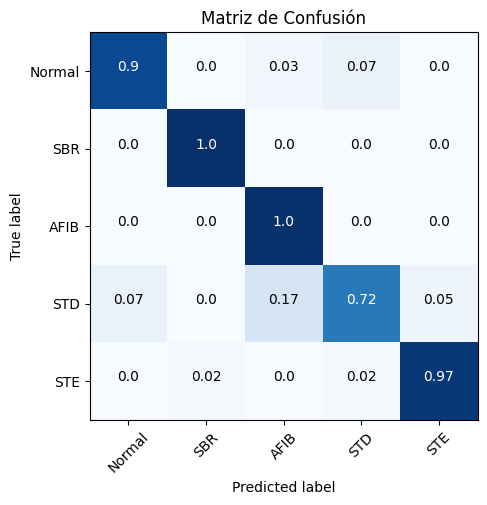

In [34]:

# cargar datos de prueba
data_test, labels_test = load_data_test_gru()
data_test=np.moveaxis(data_test,1,-2)

# Imprimiendo tamaño de test
print()

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsOptuna\\NS\\mejor_modelo_trial'
modelo='15'
Best_Model_GRU = keras.models.load_model(model_file+modelo+'.h5',custom_objects={'f1': f1})
# hacer la predicción
y_prediction = Best_Model_GRU.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\NS\\'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, ruta=ruta+'MatrizMejorModeloOptuna_NS.png',title='Matriz de Confusión',normalize=True)

# Entrenando modelo con los mejores Hiperparámetros

In [20]:
def create_model_gru():
    input_shape = (1, 241, 102)
    ModelGRU=keras.models.Sequential()

    ModelGRU.add(keras.layers.Conv1D(filters=188,kernel_size=15,strides=6,input_shape=input_shape[1:]))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Activation('relu'))
    ModelGRU.add(keras.layers.Dropout(0.7))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(0.7))

    ModelGRU.add(keras.layers.GRU(units=128,return_sequences=True))
    ModelGRU.add(keras.layers.BatchNormalization())
    ModelGRU.add(keras.layers.Dropout(0.7))
    
    ModelGRU.add(keras.layers.TimeDistributed(keras.layers.Dense(128,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3))))
    ModelGRU.add(keras.layers.Dropout(0.7))
    ModelGRU.add(keras.layers.Flatten())
    ModelGRU.add(keras.layers.Dense(64,activation="tanh",activity_regularizer=regularizers.L1L2(1e-3)))
    ModelGRU.add(keras.layers.Dropout(0.7))
    ModelGRU.add(keras.layers.Dense(5,activation="softmax",))  
    ModelGRU.summary()
    
    return ModelGRU


In [23]:
K.clear_session()
reset_keras()
data_test, labels_test_OHE,data_val, labels_val_OHE = load_data_gru()
data_val=np.moveaxis(data_val,1,-2)

# Entrenando y guardando el modelo
Best_Hiper_ModelGRU=create_model_gru()
opt = optimizers.Adam(learning_rate=0.0066398097694950866)
Best_Hiper_ModelGRU.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',tf.keras.metrics.AUC(),f1])
ruta_modelo='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsMejoresHiperparametros\\NS\\'
ruta_modelo_trial=ruta_modelo+'mejor_modelo_RNN_NS.h5'
Checkpoint = ModelCheckpoint(ruta_modelo_trial, monitor="val_accuracy", save_best_only=True, mode="max")
history=Best_Hiper_ModelGRU.fit(data_test,labels_test_OHE,verbose=1,epochs=30,batch_size=223,validation_data=(data_val,labels_val_OHE),callbacks=[Checkpoint])

52742
(360, 51, 241, 2)
Tamaño datos entrenamiento: (10015, 102, 241)
Tamaño etiquetas de entrenamiento: (10015,)
Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 38, 188)           287828    
                                                                 
 batch_normalization (BatchN  (None, 38, 188)          752       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 188)           0         
                                                                 
 dropout (Dropout)           (None, 38, 188)           0         
                                                                 
 gru (GRU)                   (None, 38, 128)           122112    
      

# Graficas modelo con los mejores hiperparámetros

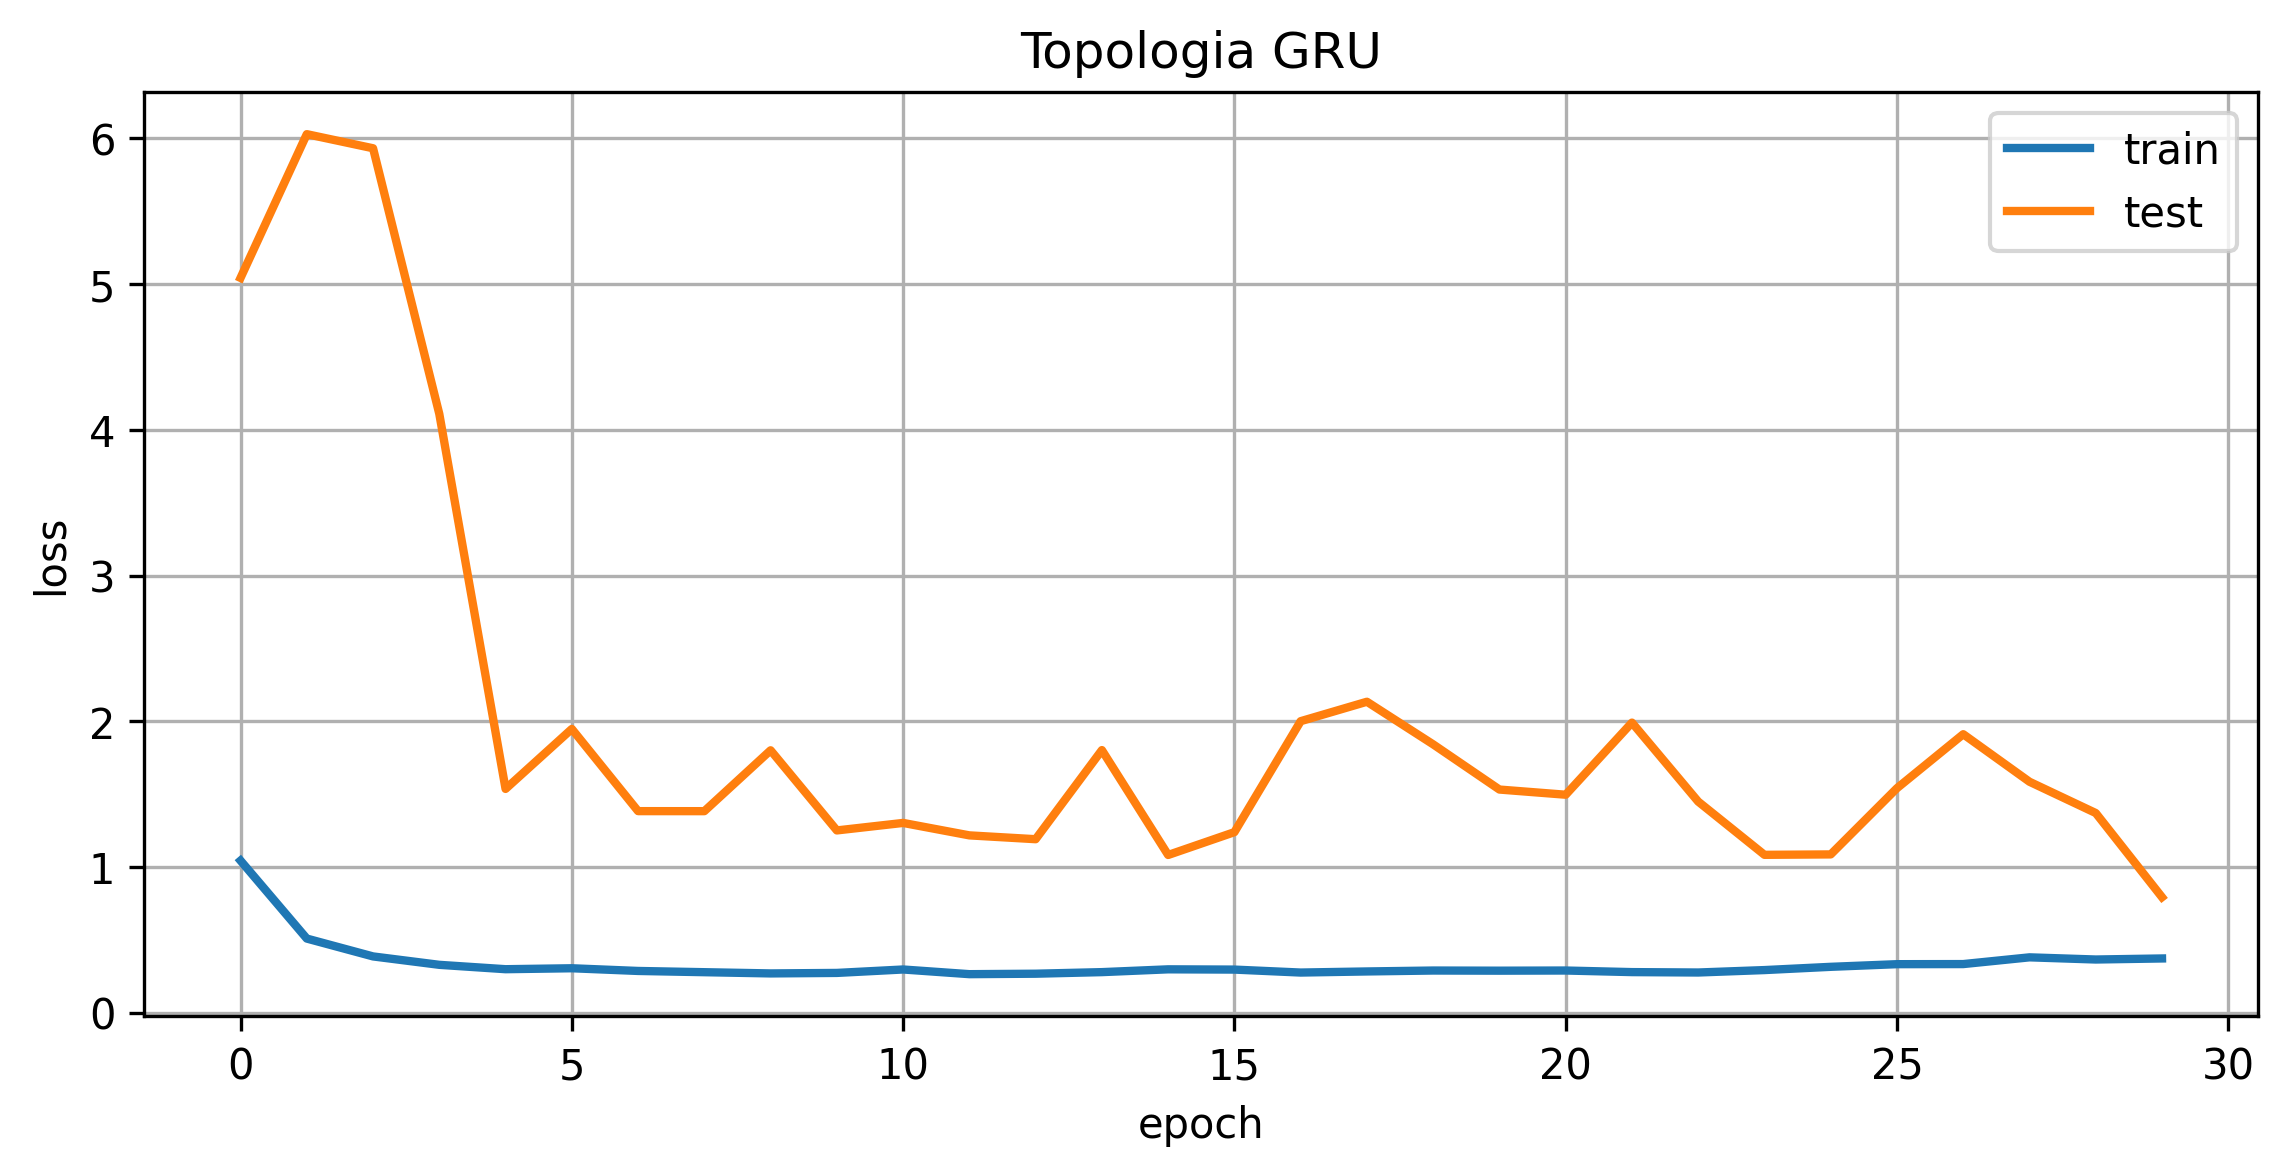

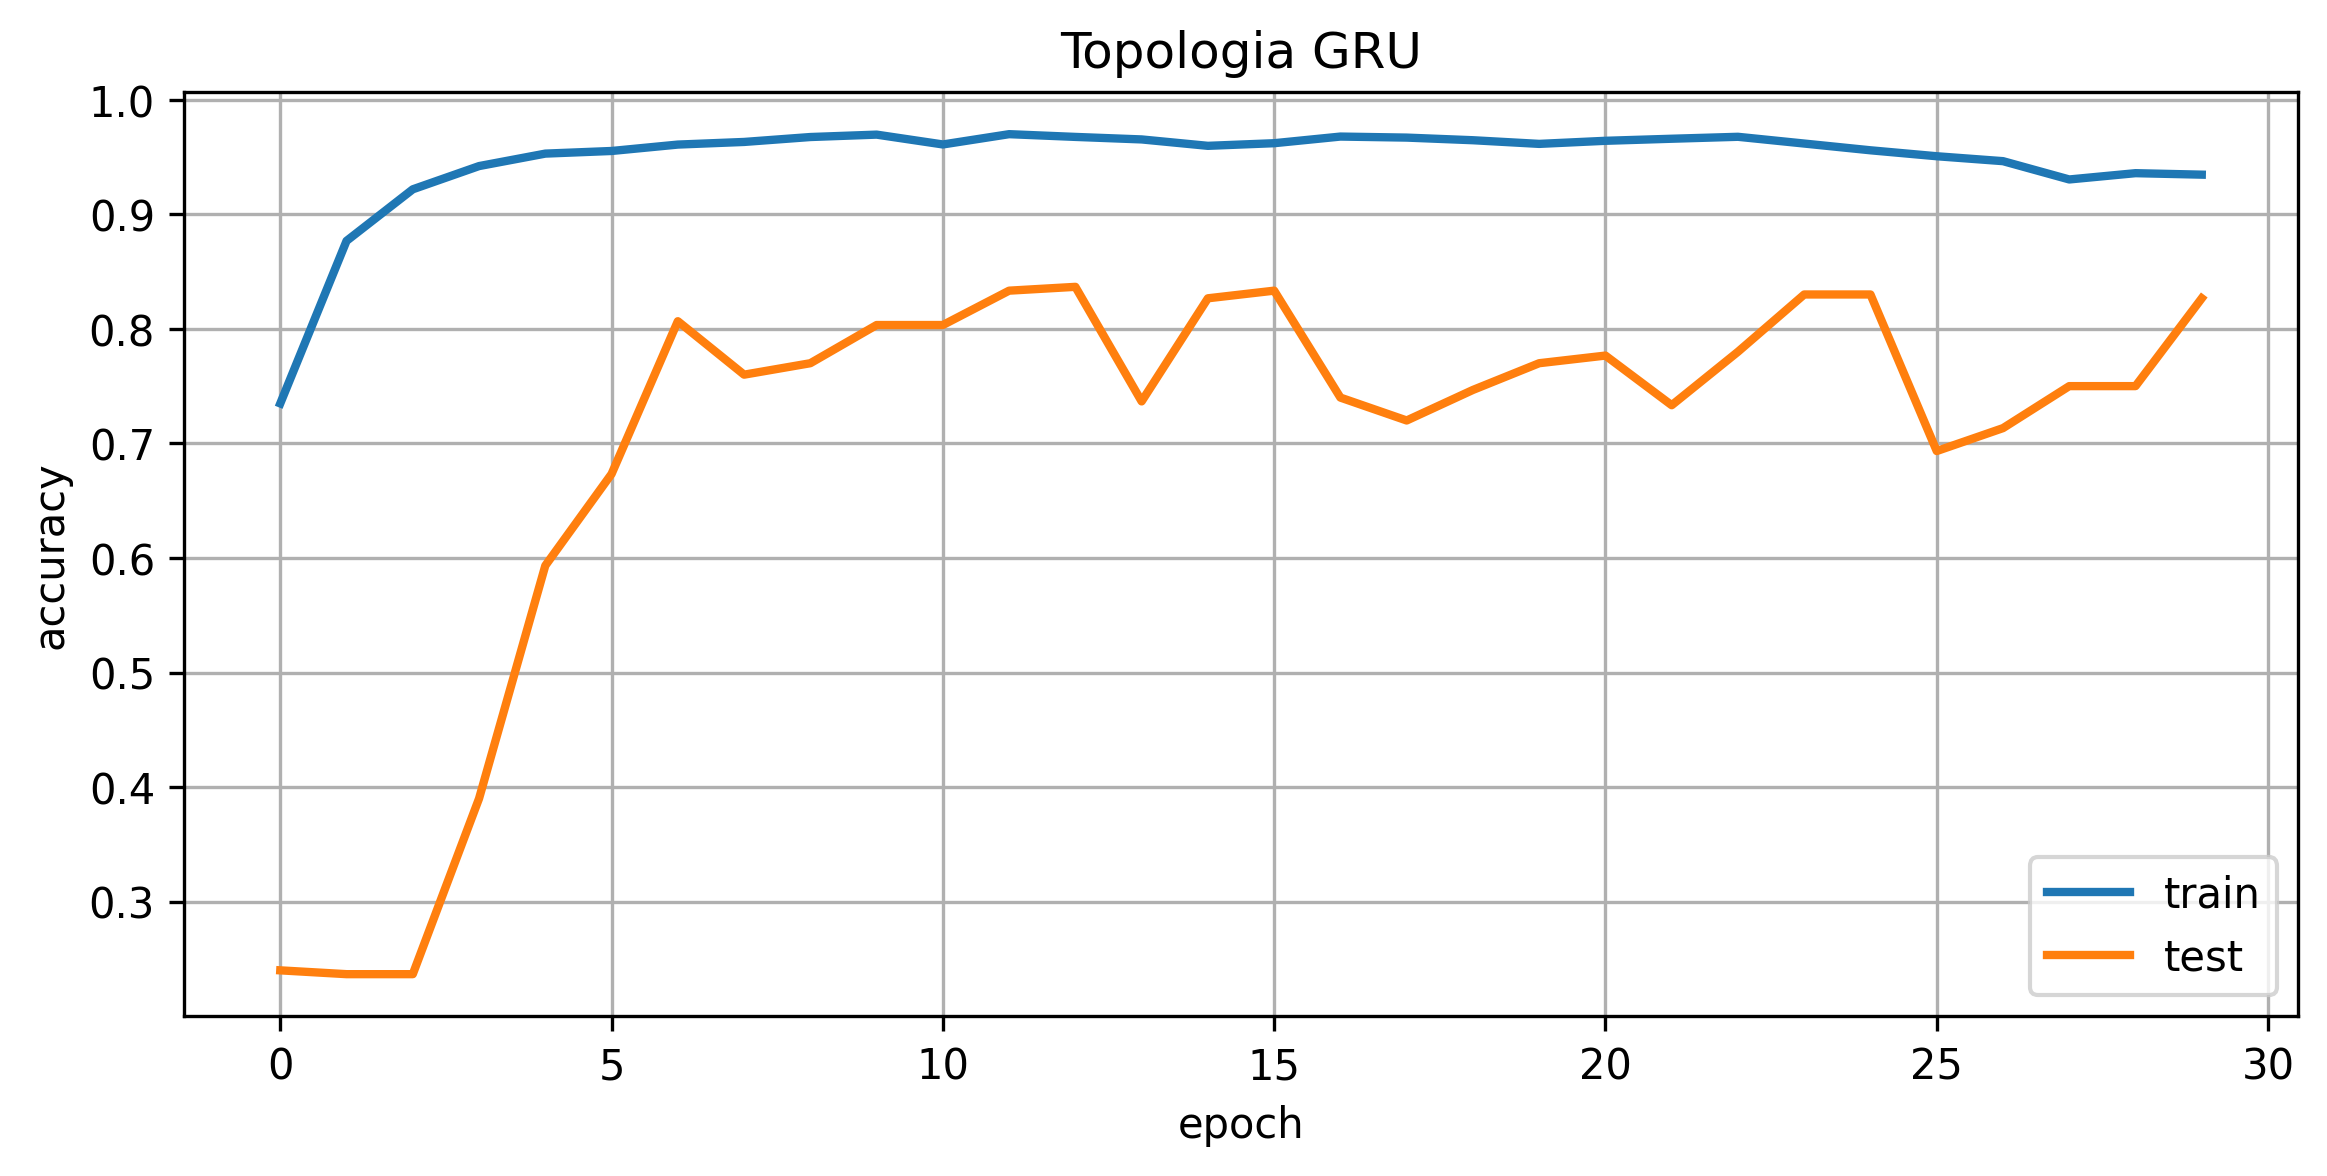

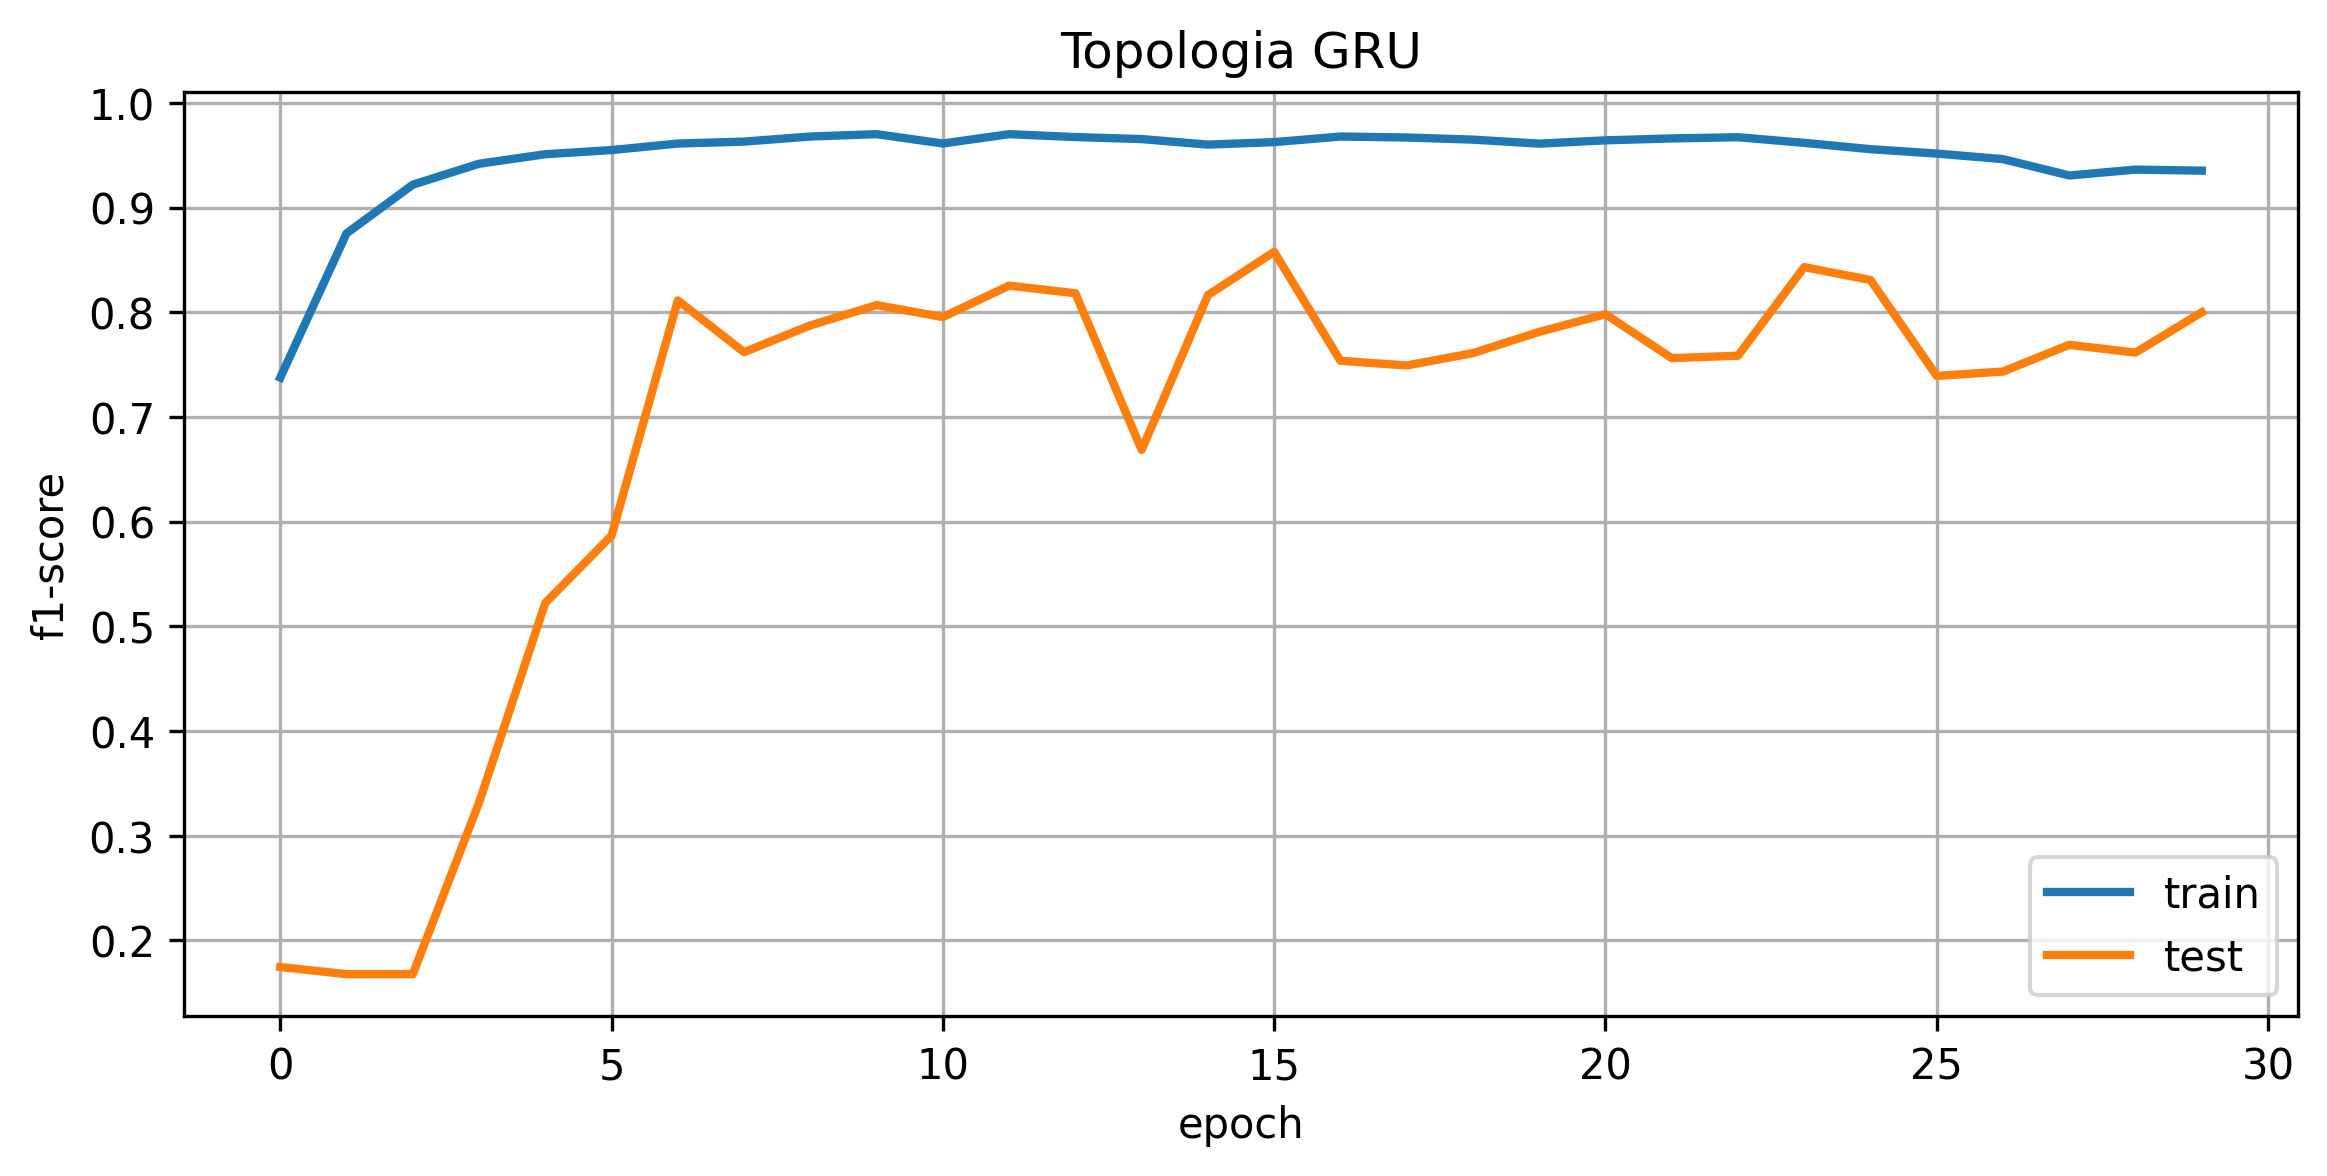

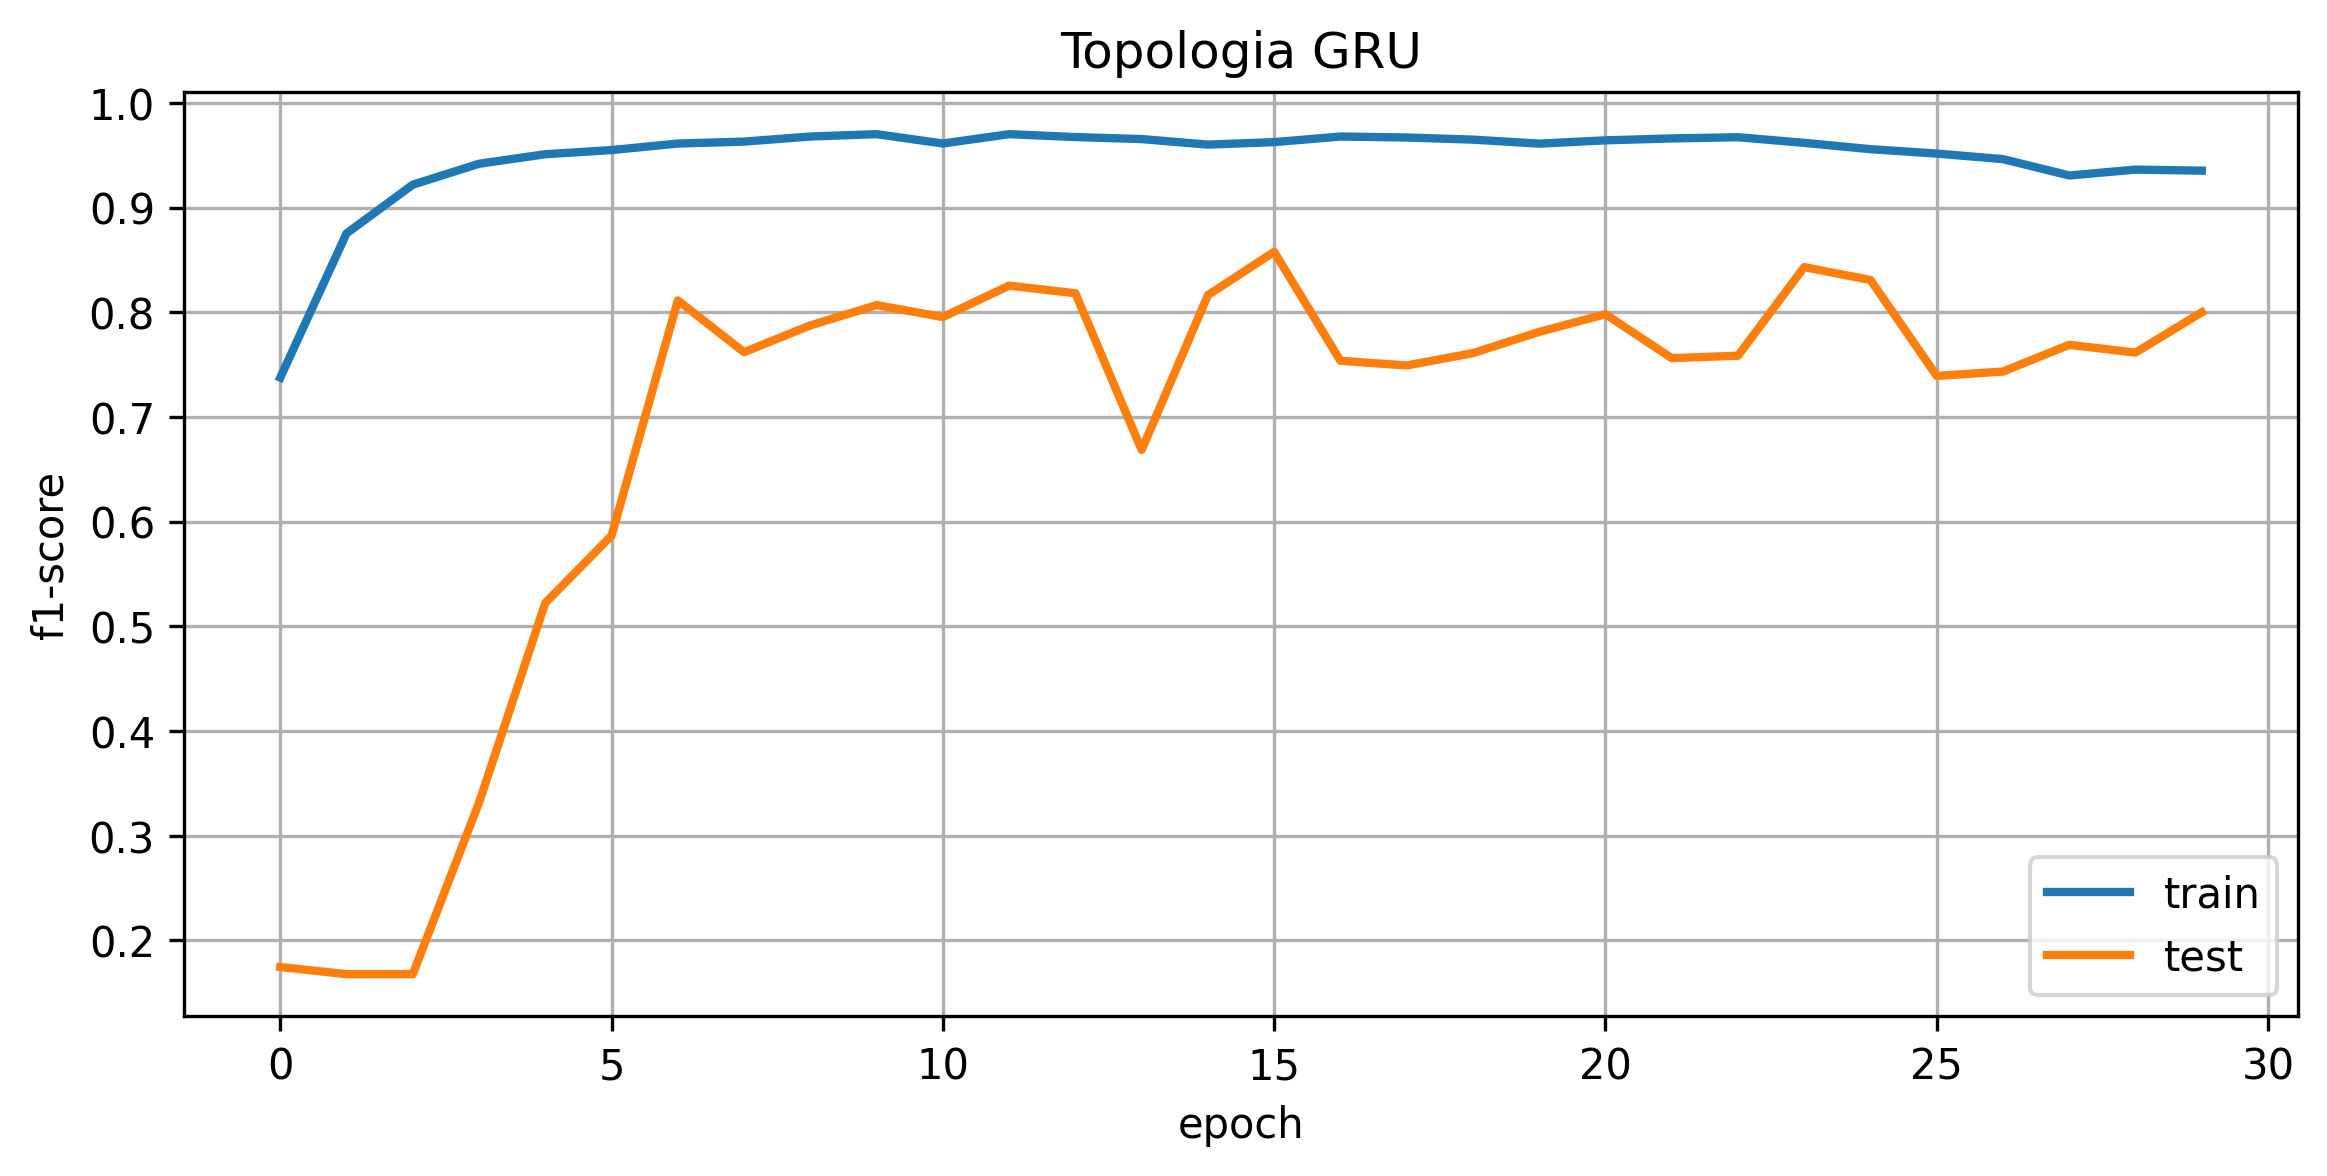

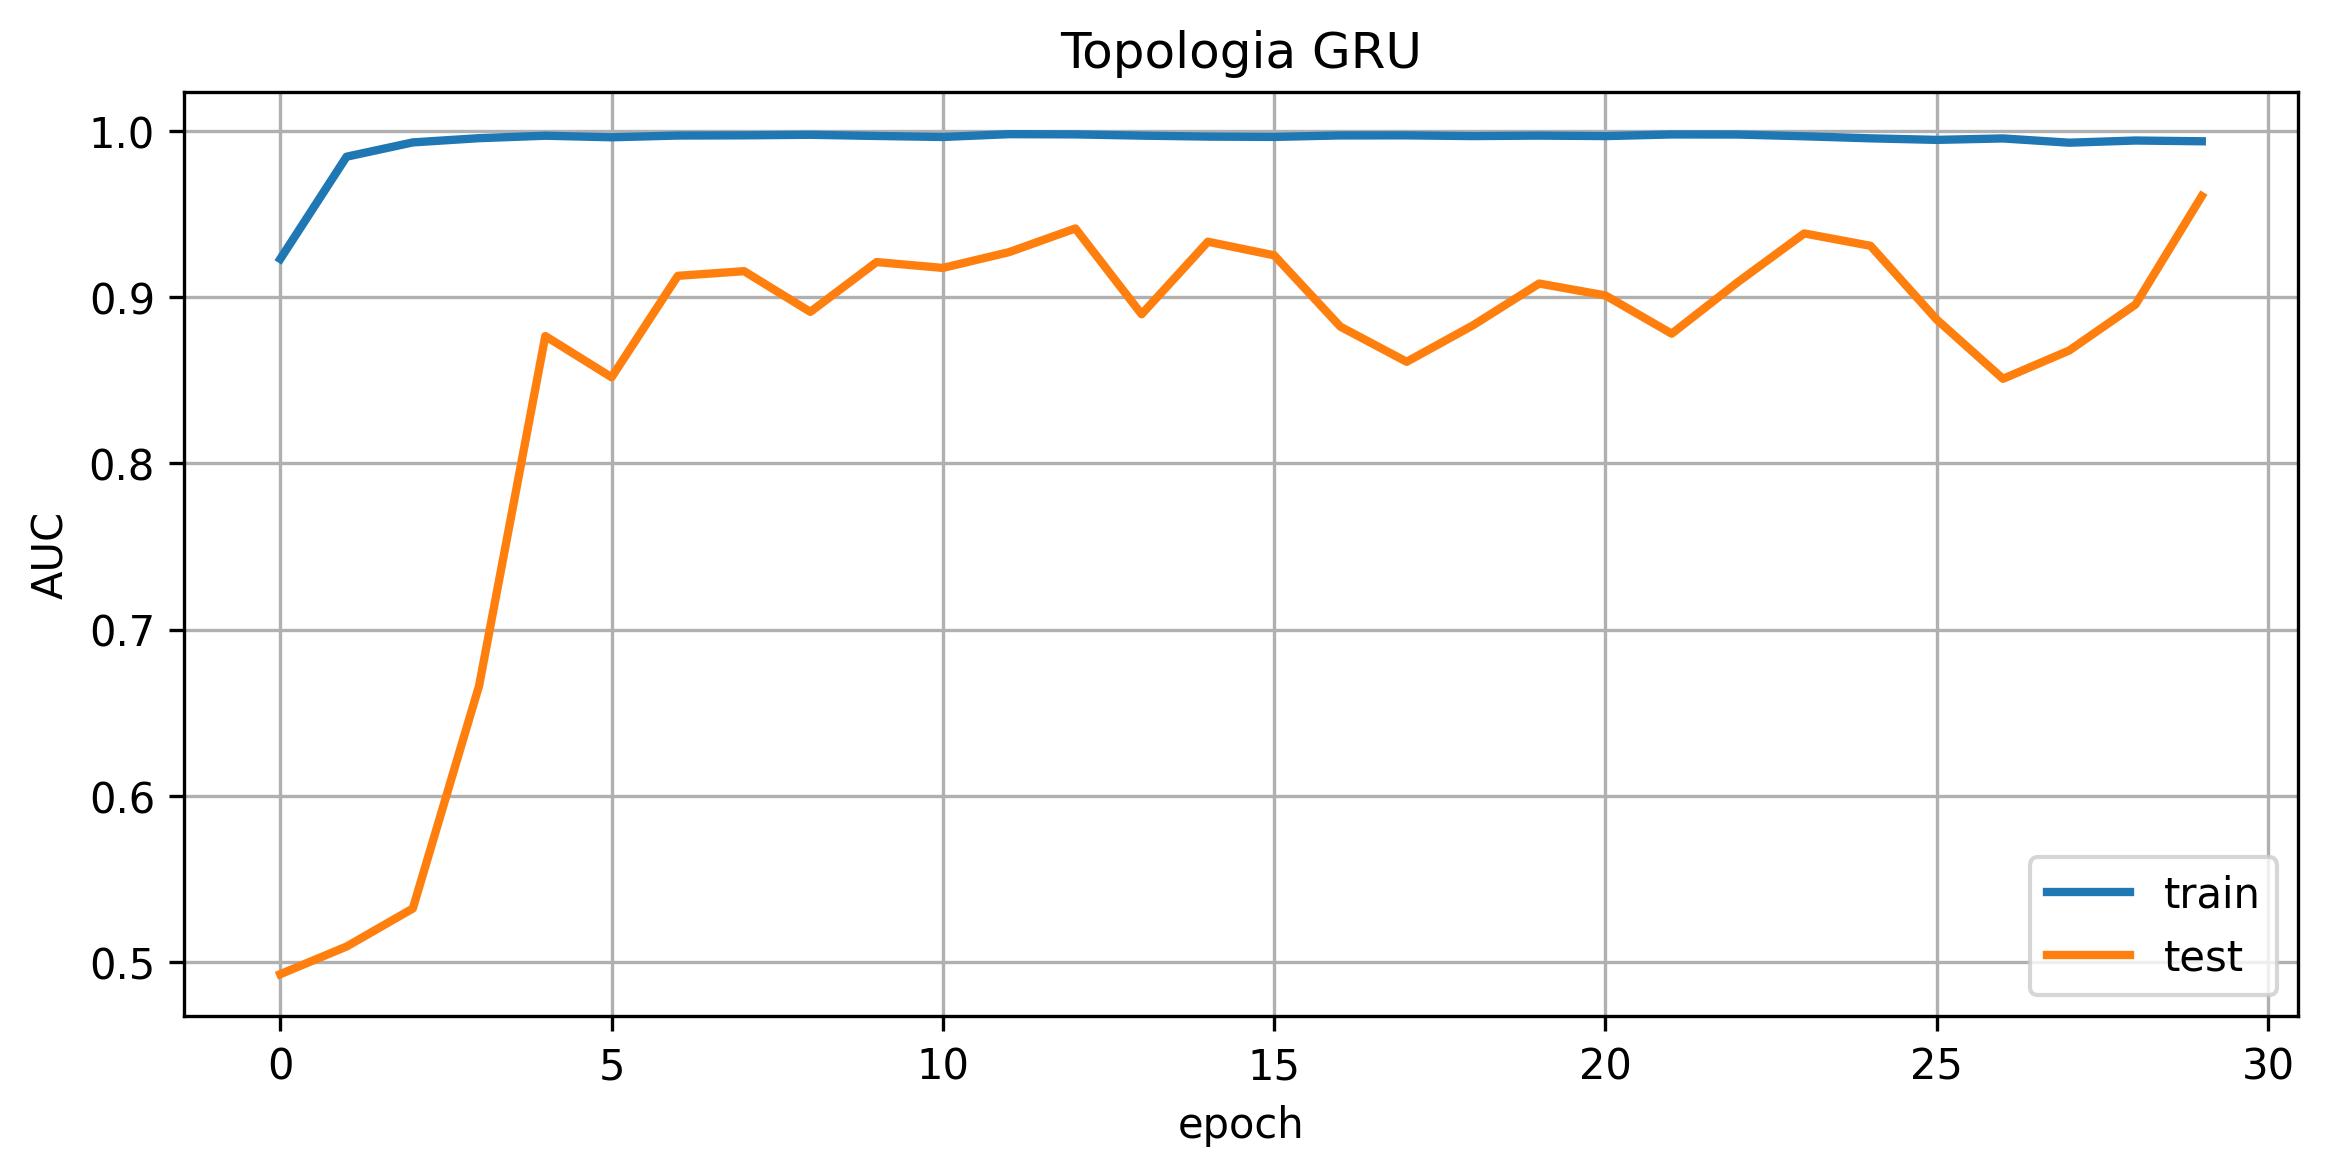

In [26]:
plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], linewidth=2, )
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Topologia GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], linewidth=2,)
plt.plot(history.history['val_accuracy'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['f1'], linewidth=2,)
plt.plot(history.history['val_f1'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

plt.figure(figsize=(20, 4),dpi=300)
plt.subplot(1,2,2)
plt.plot(history.history['auc'], linewidth=2,)
plt.plot(history.history['val_auc'], linewidth=2,)
plt.title('Topologia GRU')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.grid()
plt.show()

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 25ms/step
[[9.99804795e-01 1.37597544e-05 4.45354999e-05 1.08859895e-04
  2.81742541e-05]
 [9.99565065e-01 7.28853138e-06 8.47086048e-05 2.79647094e-04
  6.32720912e-05]
 [9.99479234e-01 5.76603770e-06 8.24989911e-05 3.52116884e-04
  8.04647279e-05]
 ...
 [7.19975040e-04 2.92164017e-03 3.86379106e-04 7.74162561e-02
  9.18555796e-01]
 [2.23245029e-03 1.23946450e-03 2.32220715e-04 1.98929533e-01
  7.97366321e-01]
 [2.60833721e-03 4.94517953e-05 2.67787604e-04 8.15496564e-01
  1.81577876e-01]]
Normalized confusion matrix
[[0.82 0.   0.13 0.05 0.  ]
 [0.   0.87 0.   0.   0.13]
 [0.02 0.   0.98 0.   0.  ]
 [0.05 0.02 0.18 0.73 0.02]
 [0.   0.   0.   0.2  0.8 ]]


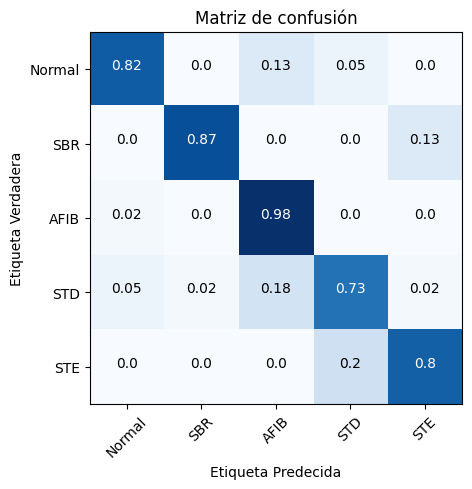

In [27]:
data_test, labels_test = load_data_test_gru()
data_test=np.moveaxis(data_test,1,-2)
y_prediction = Best_Hiper_ModelGRU.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\NS\\MatrizDatosTestModeloEntrenadoNS.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta, title='Matriz de confusión',normalize=True)

# Mejor modelo entrenado del modelo de hiperparámetros

Tamaño datos test: (300, 102, 241)
Tamaño etiquetas de test: (300,)
10/10 [==============================] - 1s 21ms/step
[[2.9893417e-05 1.2039313e-02 1.3814510e-04 3.4234487e-02 9.5355821e-01]
 [9.9911231e-01 2.7076536e-05 1.9498089e-05 6.8636227e-04 1.5486585e-04]
 [9.9987864e-01 4.6625797e-07 1.8094492e-05 9.4745541e-05 8.0203745e-06]
 ...
 [2.1114802e-05 3.1231288e-03 4.0315466e-05 3.4490012e-02 9.6232539e-01]
 [2.1019538e-05 3.1576161e-03 4.0820516e-05 3.4299601e-02 9.6248102e-01]
 [3.0237756e-04 4.4984825e-02 1.2643328e-04 2.7349543e-02 9.2723686e-01]]
Normalized confusion matrix
[[0.88 0.   0.   0.02 0.1 ]
 [0.   1.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.03]
 [0.15 0.   0.13 0.3  0.42]
 [0.02 0.   0.   0.   0.98]]


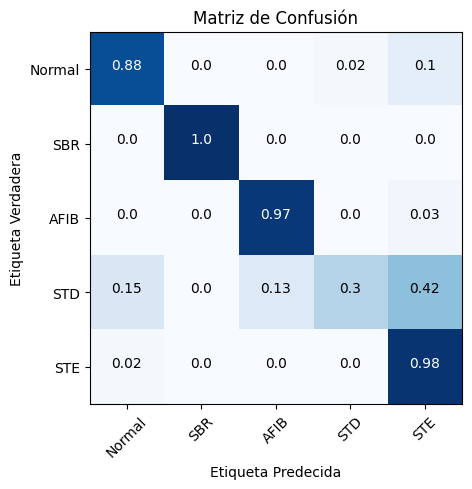

In [30]:
# cargar datos de prueba
data_test, labels_test = load_data_test_gru()
# data_test=np.moveaxis(data_test,1,-2)

# cargar modelo previamente entrenado
model_file = 'C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModelosCheckpointsMejoresHiperparametros\\NS\\'
ModelGRU_best = keras.models.load_model(model_file+'mejor_modelo_RNN_NS.h5',custom_objects={"f1": f1})
# hacer la predicción
y_prediction = ModelGRU_best.predict(data_test)
print(y_prediction)
rounded_predictions=np.argmax(y_prediction,axis=1)

# obtener matriz de confusión y graficarla
cm = confusion_matrix(y_true=labels_test, y_pred=rounded_predictions)
cm_plot_labels = ['Normal','SBR','AFIB','STD','STE']
ruta='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\MatricesDeConfusion\\NS\\\MatrizDatosTestMejorModeloEntrenadoNS.png'
plot_confusion_matrix(cm=cm, classes=cm_plot_labels,ruta=ruta,title='Matriz de Confusión',normalize=True)

# Guardando datos del modelo entrenado

In [31]:
import json
#Guardando historiales
path='C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\NS\\'
with open(path+'historial_Modelo_RNN_NS_final.json', 'w') as f:
    json.dump(history.history, f)

#Guardando mejor modelo
Best_Hiper_ModelGRU.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\NS\\Modelo_RNN_NS_final.h5')
ModelGRU_best.save('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\ModeloMejoresHiperparametros\\NS\\Modelo_RNN_NS_Best_final.h5')

In [35]:
datos={
    'f1':[0.7496, 0.8880, 0.9245, 0.9435, 0.9509, 0.9559, 0.9686, 0.9686, 0.9698, 0.9739, 0.9598, 0.9643, 0.9644, 0.9661, 0.9643, 0.9687, 0.9676, 0.9695, 0.9663, 0.9663],
    'accuracy':[0.7506, 0.8872, 0.9258, 0.9442, 0.9515, 0.9558, 0.9683, 0.9687, 0.9698, 0.9743, 0.9597, 0.9642, 0.9645, 0.9660, 0.9639, 0.9686, 0.9676, 0.9698, 0.9659, 0.9663],
    'auc':[0.9285, 0.9285, 0.9937, 0.9950, 0.9964, 0.9962, 0.9978, 0.9976, 0.9983, 0.9982, 0.9966, 0.9972, 0.9969, 0.9974, 0.9972, 0.9975, 0.9973, 0.9979, 0.9974, 0.9967],
    'val_f1':[0.1332, 0.1368, 0.1476, 0.4086, 0.6982, 0.7718, 0.8583, 0.8539, 0.8297, 0.8317, 0.8432, 0.8129, 0.8613, 0.8441, 0.9095, 0.8050, 0.8348, 0.8387, 0.7344, 0.9165],
    'val_accuracy':[0.1967, 0.2033, 0.2067, 0.4767, 0.6967, 0.7900, 0.8133, 0.8333, 0.8300, 0.8200, 0.8067, 0.8167, 0.8700, 0.8567, 0.9033, 0.7733, 0.8133, 0.8233, 0.7367, 0.9100],
    'val_auc':[0.6178, 0.5393, 0.5610, 0.7367, 0.8578, 0.9171, 0.8958, 0.9265, 0.9359, 0.9249, 0.9017, 0.9346, 0.9382, 0.9540, 0.9525, 0.8951, 0.9178, 0.9322, 0.8697, 0.9595]
}

In [36]:
import numpy as np
index_max=np.argmax(datos['val_accuracy'])
print('val_accuracy:',datos['val_accuracy'][index_max]*100)

index_max=np.argmax(datos['accuracy'])
print('accuracy:',datos['accuracy'][index_max]*100)

index_max=np.argmax(datos['val_f1'])
print('val_f1:',datos['val_f1'][index_max]*100)

index_max=np.argmax(datos['f1'])
print('f1:',datos['f1'][index_max]*100)

index_max=np.argmax(datos['val_auc'])
print('val_auc:',datos['val_auc'][index_max]*100)

index_max=np.argmax(datos['auc'])
print('auc:',datos['auc'][index_max]*100)

val_accuracy: 91.0
accuracy: 97.43
val_f1: 91.64999999999999
f1: 97.39
val_auc: 95.95
auc: 99.83


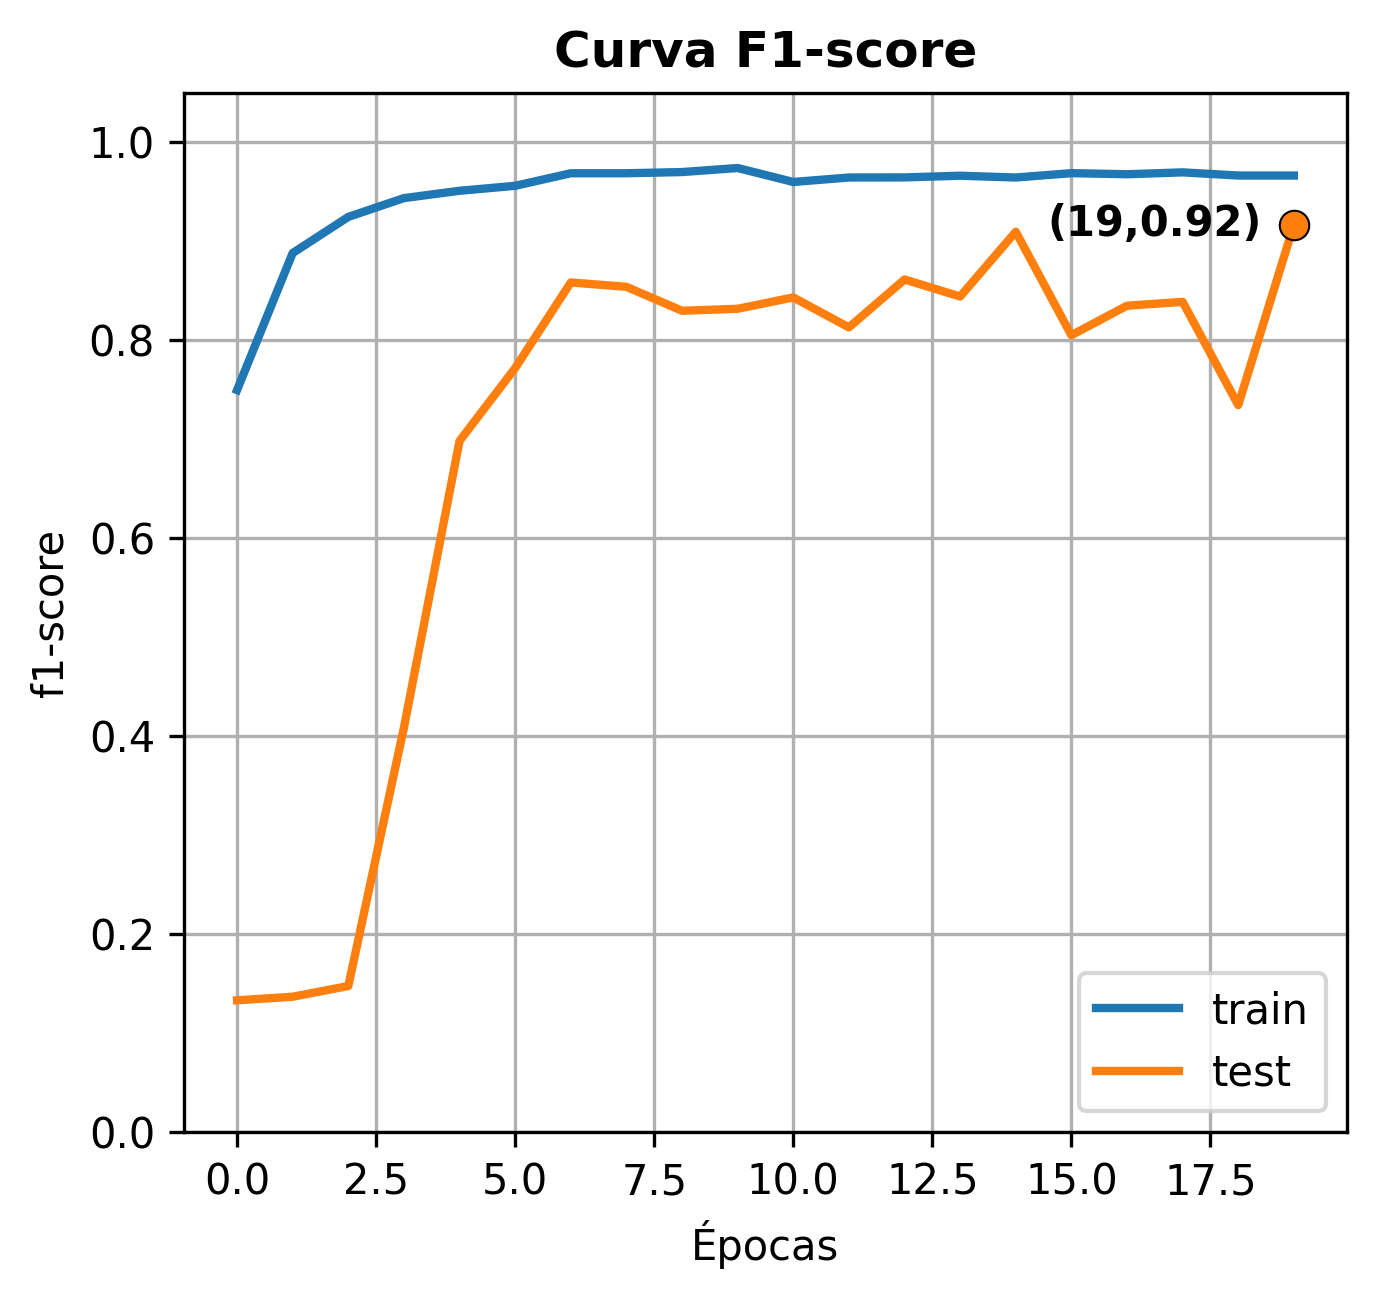

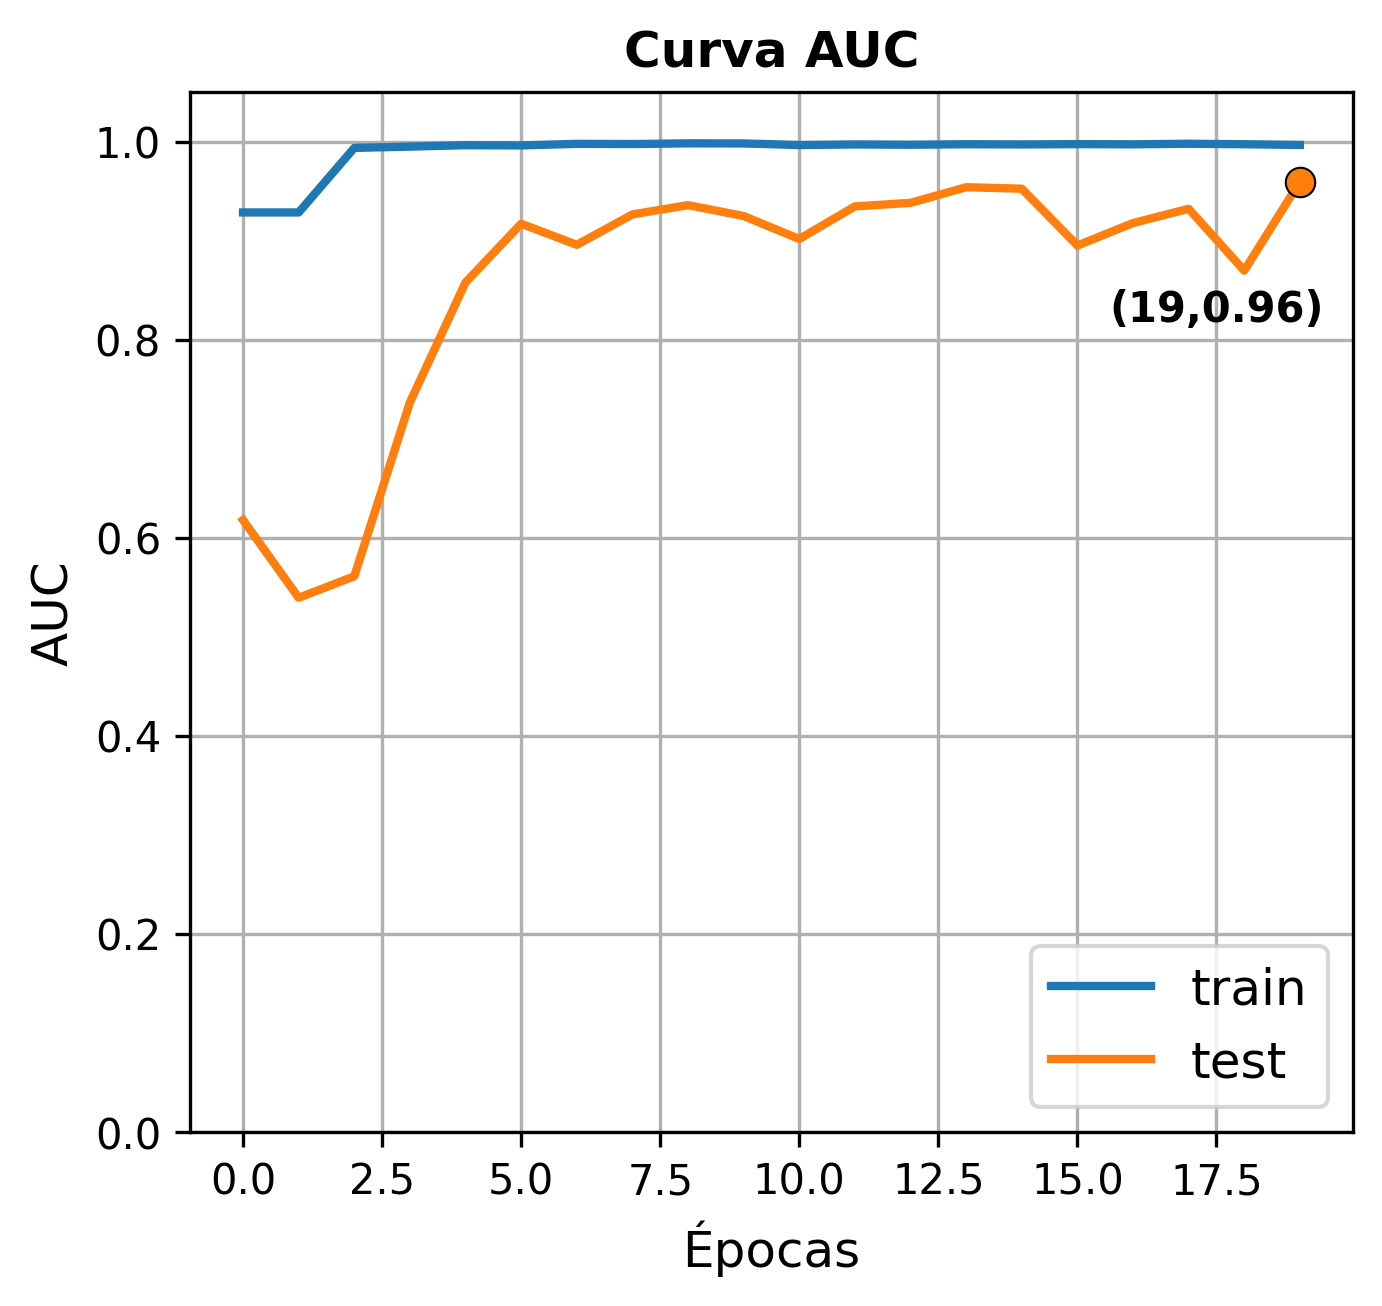

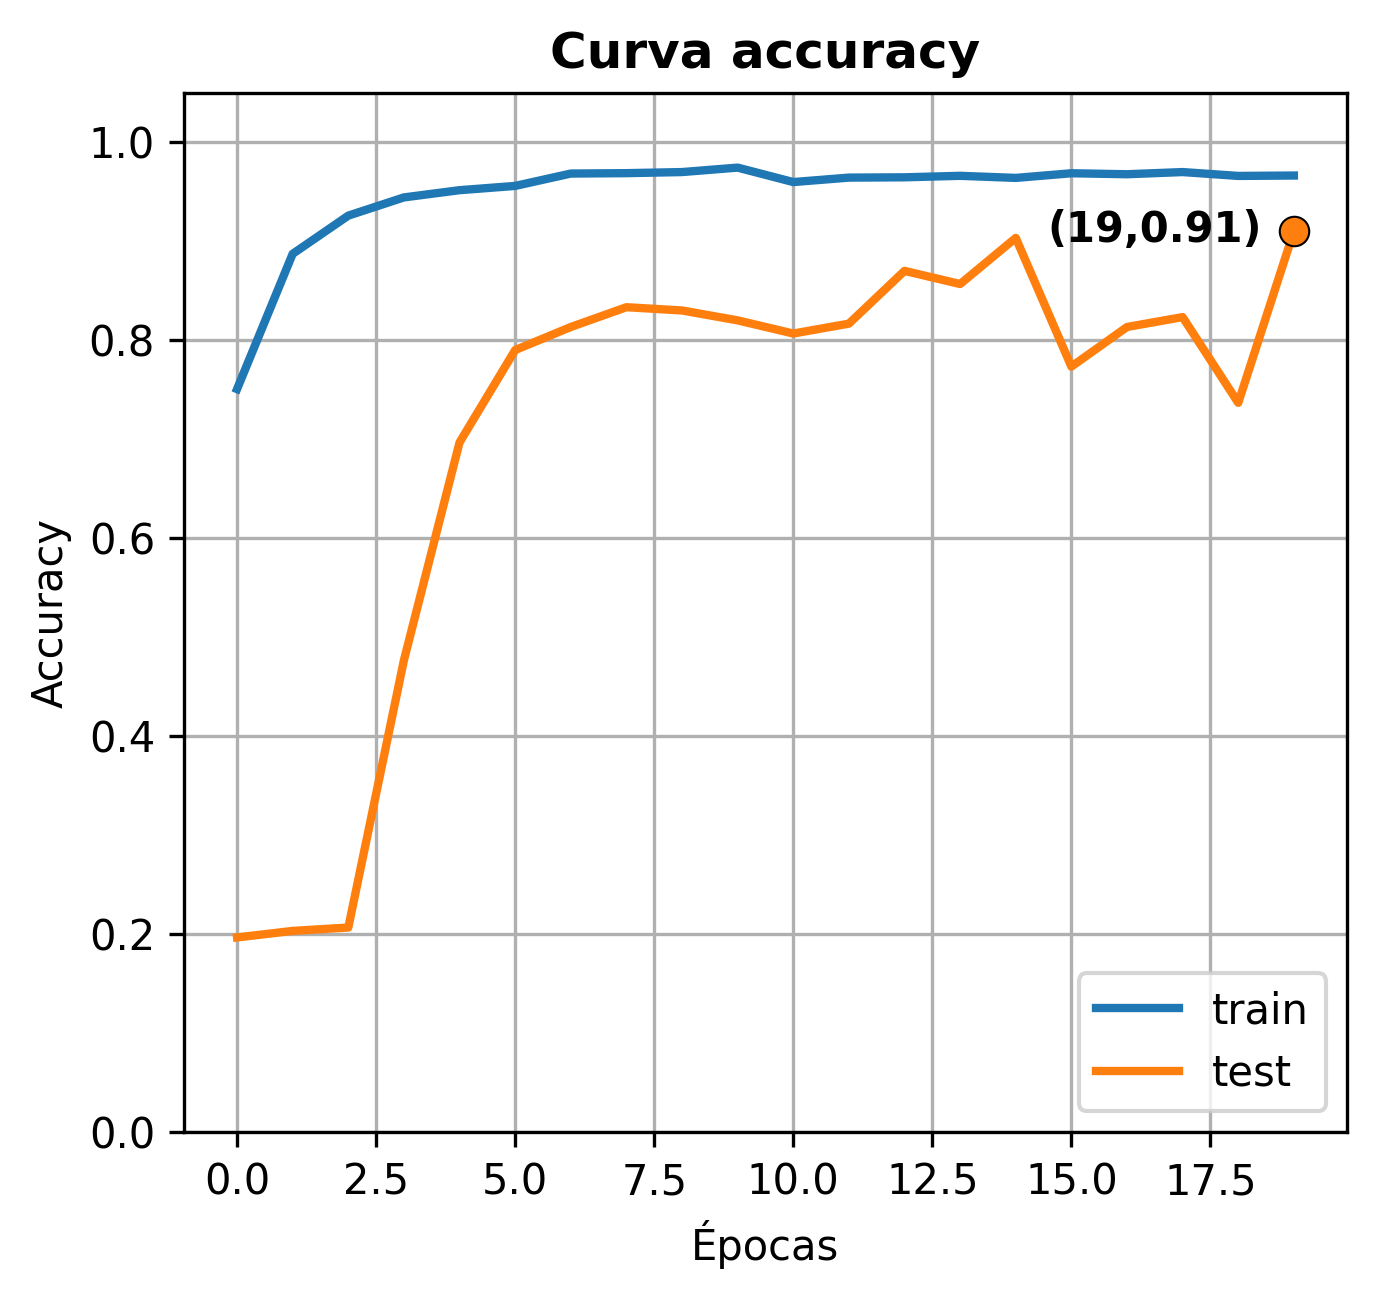

In [32]:
# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['f1'], linewidth=2,)
ax2.plot(datos['val_f1'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('f1-score')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_f1'])
y_max = datos['val_f1'][index_max]

t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-2.5, y_max-0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva F1-score',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\NS\\subfigura2.png', dpi=300)

# Mostrar la figura
plt.show()



# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['auc'], linewidth=2,)
ax2.plot(datos['val_auc'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('AUC',fontsize=12)
ax2.set_xlabel('Épocas',fontsize=12)
ax2.legend(['train', 'test'],loc='lower right',fontsize=12)
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_auc'])
y_max = datos['val_auc'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-1.5, y_max-0.15, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva AUC',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\NS\\subfigura3.png', dpi=300)

# Mostrar la figura
plt.show()

# Crear una nueva figura con solo la subfigura 3
fig2, ax2 = plt.subplots(figsize=(5,4.5), dpi=300)
ax2.plot(datos['accuracy'], linewidth=2,)
ax2.plot(datos['val_accuracy'], linewidth=2,color='#FF7F0E')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Épocas')
ax2.legend(['train', 'test'],loc='lower right')
ax2.grid()

# Encontrar el índice y el valor máximo
index_max = np.argmax(datos['val_accuracy'])
y_max = datos['val_accuracy'][index_max]
t_max = index_max

# Plotear el punto relleno en el valor máximo y agregar la etiqueta
ax2.scatter(t_max, y_max, color='#FF7F0E', edgecolors='k', linewidths=0.5, s=50, zorder=3)
ax2.text(t_max-2.5, y_max-0.02, f'({t_max},{y_max:.2f})', ha='center', va='bottom', color='k',fontweight='bold')

# Establecer el rango máximo en el eje Y
y_max = 1.05
ax2.set_ylim([0, y_max])

plt.title('Curva accuracy',fontweight='bold')

# Guardar la figura en un archivo separado
plt.savefig('C:\\Users\\jdani\\Documents\\TrabajoDeGrado\\Arquitecturas\\ArquitecturaRecurrente\\Imagenes\\NS\\subfigura1.png', dpi=300)

# Mostrar la figura
plt.show()